# Padrões Frequentes

In [35]:
import pandas as pd
import re
import numpy as np
from mlxtend.frequent_patterns import apriori, fpgrowth
from mlxtend.frequent_patterns import association_rules

In [36]:
df = pd.read_csv("Eventos.csv")

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [38]:
df

timestamp  visitorid event  itemid  transactionid
0        1433221332117     257597  view  355908            NaN
1        1433224214164     992329  view  248676            NaN
2        1433221999827     111016  view  318965            NaN
3        1433221955914     483717  view  253185            NaN
4        1433221337106     951259  view  367447            NaN
...                ...        ...   ...     ...            ...
2756096  1438398785939     591435  view  261427            NaN
2756097  1438399813142     762376  view  115946            NaN
2756098  1438397820527    1251746  view   78144            NaN
2756099  1438398530703    1184451  view  283392            NaN
2756100  1438400163914     199536  view  152913            NaN

[2756101 rows x 5 columns]

O Timestamp vai de 3 de Maio de 2015 a 18 de Setembro de 2015 (obtidos em: https://www.epochconverter.com/)

In [39]:
from time import strftime, localtime
mi, ma = df["timestamp"].min(), df["timestamp"].max()
print(mi, ma)

1430622004384 1442545187788


In [40]:
def tem_caracteres(x):
    matches = re.match(r".*[_a-zA-Z\s-]", str(x))
    return matches != None

Vamos validar se `timestamp`, `visitorid` e `itemid` têm algum valor não inteiro

In [41]:
df[df["timestamp"].apply(tem_caracteres) == True]

Empty DataFrame
Columns: [timestamp, visitorid, event, itemid, transactionid]
Index: []

In [42]:
df[df["visitorid"].apply(tem_caracteres) == True]

Empty DataFrame
Columns: [timestamp, visitorid, event, itemid, transactionid]
Index: []

In [43]:
df[df["itemid"].apply(tem_caracteres) == True]

Empty DataFrame
Columns: [timestamp, visitorid, event, itemid, transactionid]
Index: []

Como se pode observar o datafram vem totalmente vazio, logo não há qualquer valor não inteiro nestas 3 colunas.

In [44]:
df["visitorid"].nunique()

1407580

In [45]:
df["event"].value_counts()

event
view           2664312
addtocart        69332
transaction      22457
Name: count, dtype: int64

Há mais ações de visualização, além de haver 3 tipos de ações:
* Visualização: Supõe-se que seja visualização de algum item
* Adicionar ao carrinho: Supõe-se que seja adicionar um item ao carrinho
* Transação: Supõe-se que foi feita alguma compra de um item

As colunas `timestamp` e `transactionid`, não serão utilizadas, devido às seguintes razões:
* O `timestamp` serve apenas como medida temporal, o que para a criação de regras de associação não parece ser algo importante
* O `transactionid` é redundante, dado que a coluna `event` já tem uma ação denominada de **transaction**

In [46]:
counts = df.groupby(['itemid', 'event']).size().unstack(fill_value=0)
filtered_items = counts[(counts['addtocart'] > 0) & (counts['transaction'] > 0)]
itens = filtered_items.index.tolist()

In [47]:
df_itens_filtrado = df[df['itemid'].isin(itens)]

In [48]:
counts = df_itens_filtrado.groupby(['visitorid', 'event']).size().unstack(fill_value=0)

In [49]:
filtered_visitors = counts[(counts['view'] > 0) & (counts['addtocart'] > 0) & (counts['transaction'] > 0)]
visitors = filtered_visitors.index.tolist()

In [50]:
df_visitors_filtrado = df[df['visitorid'].isin(visitors)].copy()
df_visitors_filtrado

timestamp  visitorid      event  itemid  transactionid
19       1433221078505     158090  addtocart   10572            NaN
27       1433222147345    1076270       view  262799            NaN
106      1433221123646    1076270       view  269430            NaN
110      1433221740333     712443       view  346655            NaN
112      1433221941632     599528  addtocart  356475            NaN
...                ...        ...        ...     ...            ...
2755945  1438397263804     532307       view   89232            NaN
2755952  1438398205600    1016212       view  162038            NaN
2756008  1438402186555     175890       view  396732            NaN
2756030  1438400558113     118200       view  174923            NaN
2756094  1438399289446     701750       view  296172            NaN

[221104 rows x 5 columns]

In [51]:
df_visitors_filtrado["visitorid"].nunique()

10124

In [52]:
df_visitors_filtrado["itemid"].nunique()

35657

In [53]:
df_visitors_filtrado.drop(columns=["timestamp", "transactionid"], inplace=True)

In [54]:
df_visitors_filtrado

visitorid      event  itemid
19          158090  addtocart   10572
27         1076270       view  262799
106        1076270       view  269430
110         712443       view  346655
112         599528  addtocart  356475
...            ...        ...     ...
2755945     532307       view   89232
2755952    1016212       view  162038
2756008     175890       view  396732
2756030     118200       view  174923
2756094     701750       view  296172

[221104 rows x 3 columns]

In [55]:
def encode(x):
    if x == "view": return 0
    return 1

df_visitors_filtrado["event"] = df_visitors_filtrado["event"].apply(encode)

In [56]:
df_visitors_filtrado

visitorid  event  itemid
19          158090      1   10572
27         1076270      0  262799
106        1076270      0  269430
110         712443      0  346655
112         599528      1  356475
...            ...    ...     ...
2755945     532307      0   89232
2755952    1016212      0  162038
2756008     175890      0  396732
2756030     118200      0  174923
2756094     701750      0  296172

[221104 rows x 3 columns]

In [57]:
pivot = pd.pivot_table(
    df_visitors_filtrado, index="visitorid", 
    columns=["itemid"], values="event", aggfunc="sum", 
    fill_value=0).astype(bool)

In [58]:
pivot

itemid     15      17      19      25      42      66      71      102     \
visitorid                                                                   
172         False   False   False   False   False   False   False   False   
186         False   False   False   False   False   False   False   False   
264         False   False   False   False   False   False   False   False   
419         False   False   False   False   False   False   False   False   
539         False   False   False   False   False   False   False   False   
...           ...     ...     ...     ...     ...     ...     ...     ...   
1406564     False   False   False   False   False   False   False   False   
1406708     False   False   False   False   False   False   False   False   
1406981     False   False   False   False   False   False   False   False   
1407070     False   False   False   False   False   False   False   False   
1407110     False   False   False   False   False   False   False   False   

itemid     124     147     ...  466738  466740  466747  466757  466759  \
visitorid                  ...                                           
172         False   False  ...   False   False   False   False   False   
186         False   False  ...   False   False   False   False   False   
264         False   False  ...   False   False   False   False   False   
419         False   False  ...   False   False   False   False   False   
539         False   False  ...   False   False   False   False   False   
...           ...     ...  ...     ...     ...     ...     ...     ...   
1406564     False   False  ...   False   False   False   False   False   
1406708     False   False  ...   False   False   False   False   False   
1406981     False   False  ...   False   False   False   False   False   
1407070     False   False  ...   False   False   False   False   False   
1407110     False   False  ...   False   False   False   False   False   

itemid     466781  466796  466843  466861  466864  
visitorid                                          
172         False   False   False   False   False  
186         False   False   False   False   False  
264         False   False   False   False   False  
419         False   False   False   False   False  
539         False   False   False   False   False  
...           ...     ...     ...     ...     ...  
1406564     False   False   False   False   False  
1406708     False   False   False   False   False  
1406981     False   False   False   False   False  
1407070     False   False   False   False   False  
1407110     False   False   False   False   False  

[10124 rows x 35657 columns]

In [59]:
freq_sets = fpgrowth(pivot, min_support=0.001, use_colnames=True)

In [60]:
freq_sets

support          itemsets
0    0.001185          (172894)
1    0.002568           (46156)
2    0.004642            (7943)
3    0.001087           (65273)
4    0.001284          (210087)
..        ...               ...
103  0.003457  (213834, 445351)
104  0.001284   (10572, 461686)
105  0.001284  (171878, 461686)
106  0.001087   (32581, 461686)
107  0.001383  (218794, 461686)

[108 rows x 2 columns]

In [61]:
regras = association_rules(freq_sets, metric="lift")

In [62]:
regras.sort_values("lift", ascending = False)[:10].reset_index()

index antecedents consequents  antecedent support  consequent support  \
0      2    (213834)    (445351)            0.007309            0.004149   
1      3    (445351)    (213834)            0.004149            0.007309   
2      0    (312728)    (409804)            0.004050            0.003753   
3      1    (409804)    (312728)            0.003753            0.004050   
4      8     (32581)    (461686)            0.001087            0.012446   
5      9    (461686)     (32581)            0.012446            0.001087   
6     10    (218794)    (461686)            0.001778            0.012446   
7     11    (461686)    (218794)            0.012446            0.001778   
8      7    (461686)    (171878)            0.012446            0.001679   
9      6    (171878)    (461686)            0.001679            0.012446   

    support  confidence        lift  leverage  conviction  zhangs_metric  
0  0.003457    0.472973  114.009009  0.003427    1.889564       0.998527  
1  0.003457    0.833333  114.009009  0.003427    5.956144       0.995358  
2  0.001284    0.317073   84.474968  0.001269    1.458790       0.992180  
3  0.001284    0.342105   84.474968  0.001269    1.513844       0.991885  
4  0.001087    1.000000   80.349206  0.001073         inf       0.988628  
5  0.001087    0.087302   80.349206  0.001073    1.094462       1.000000  
6  0.001383    0.777778   62.493827  0.001361    4.443994       0.985751  
7  0.001383    0.111111   62.493827  0.001361    1.123000       0.996399  
8  0.001284    0.103175   61.443511  0.001263    1.113172       0.996122  
9  0.001284    0.764706   61.443511  0.001263    4.197106       0.985380

# Regressão e Classificação 

* ID: ID do Cliente -> Numérica | De intervalo
* Age: Idade -> Numérica | Rácio
* Experience: Experiência profissional -> Numérica | Rácio
* Income: Salário (anual) -> Numérica | Rácio
* ZIP.Code: Código Postal -> Categórica | Nominal
* Family: Agregado familiar -> Numérica | Rácio
* CCAvg: Score do cartão de crédito -> Numérica | Rácio 
* Education: Grau de escolaridade -> Categórica | Ordinal
* Mortgage: Tem e quanto tem de hipoteca OU não tem hipoteca -> Numérica | Rácio
* Person.Loan: **Atributo Alvo de Classificação**, foi feito ou não o empréstimo -> Categórica | Nominal
* Securities.Account: Se tem ou não uma conta de valores mobiliários -> Categórica | Nominal
* CD.Account: tem ou não uma conta poupança -> Categórica | Nominal 
* Online: tem ou não home banking -> Categórica | Nominal
* CreditCard: e tem ou não cartão de crédito -> Categórica | Nominal 

In [63]:
from urllib.request import urlopen 
from scipy.stats import pointbiserialr
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut, ParameterGrid, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, r2_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.base import clone
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pgeocode
import numpy as np
!pip install shapely==1.8.5

import plotly.figure_factory as ff
import json
import warnings 
warnings.filterwarnings('ignore')


SEED = 2024

In [64]:
df = pd.read_csv("bankloan.csv")
df

ID  Age  Experience  Income  ZIP.Code  Family  CCAvg  Education  \
0        1   25           1      49     91107       4    1.6          1   
1        2   45          19      34     90089       3    1.5          1   
2        3   39          15      11     94720       1    1.0          1   
3        4   35           9     100     94112       1    2.7          2   
4        5   35           8      45     91330       4    1.0          2   
...    ...  ...         ...     ...       ...     ...    ...        ...   
4995  4996   29           3      40     92697       1    1.9          3   
4996  4997   30           4      15     92037       4    0.4          1   
4997  4998   63          39      24     93023       2    0.3          3   
4998  4999   65          40      49     90034       3    0.5          2   
4999  5000   28           4      83     92612       3    0.8          1   

      Mortgage  Personal.Loan  Securities.Account  CD.Account  Online  \
0            0              0                   1           0       0   
1            0              0                   1           0       0   
2            0              0                   0           0       0   
3            0              0                   0           0       0   
4            0              0                   0           0       0   
...        ...            ...                 ...         ...     ...   
4995         0              0                   0           0       1   
4996        85              0                   0           0       1   
4997         0              0                   0           0       0   
4998         0              0                   0           0       1   
4999         0              0                   0           0       1   

      CreditCard  
0              0  
1              0  
2              0  
3              0  
4              1  
...          ...  
4995           0  
4996           0  
4997           0  
4998           0  
4999           1  

[5000 rows x 14 columns]

# Análise Exploratória Univariável

## Age
A idade é um variável numérica de rácio, pois o 0 tem valor absoluto.

<Axes: xlabel='Age', ylabel='Count'>

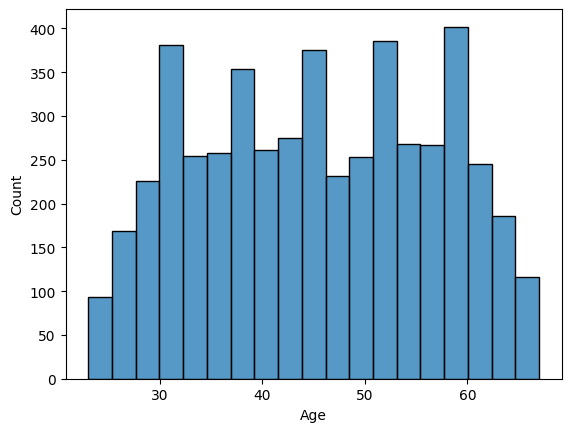

In [65]:
sns.histplot(df['Age'])

In [66]:
print("Idade mínima: ", df["Age"].min())
print("Idade máxima: ", df["Age"].max())

Idade mínima:  23
Idade máxima:  67


Pela fórmula de Sturges: $k = 1 + 3.3222 \times log_{10}(N)$, com $N$ sendo o tamanho da amostra, então $k = \lfloor15.9876\rfloor \approx 15$. Logo teremos 15 classes

Amplitude = $\frac{Lim Sup - Lim Inf}{k} = 2.75 \approx 3$ $\frac{67 - 23}{15} = 2.93 \approx 3$


[23, 26[

[26, 29[

[29, 32[

[32, 35[

[35, 38[

[38, 41[

[41, 44[

[44, 47[

[47, 50[

[50, 53[

[53, 56[

[56, 59[

[59, 62[ 

[62, 65[

[65, 68[

In [67]:
classes = pd.cut(df["Age"], 15, labels=[
    "23-25", "26-28", "29-31", "32-34", "35-37", "38-40",
    "41-43", "44-46", "47-49", "50-52", "53-55", "56-58",
    "59-61", "62-64", "65-67"])

In [68]:
classes

0       23-25
1       44-46
2       38-40
3       35-37
4       35-37
        ...  
4995    29-31
4996    29-31
4997    62-64
4998    65-67
4999    26-28
Name: Age, Length: 5000, dtype: category
Categories (15, object): ['23-25' < '26-28' < '29-31' < '32-34' ... '56-58' < '59-61' < '62-64' < '65-67']

In [69]:
classes.value_counts().sort_index()

Age
23-25     93
26-28    272
29-31    384
32-34    374
35-37    364
38-40    373
41-43    411
44-46    375
47-49    346
50-52    412
53-55    380
56-58    410
59-61    381
62-64    309
65-67    116
Name: count, dtype: int64

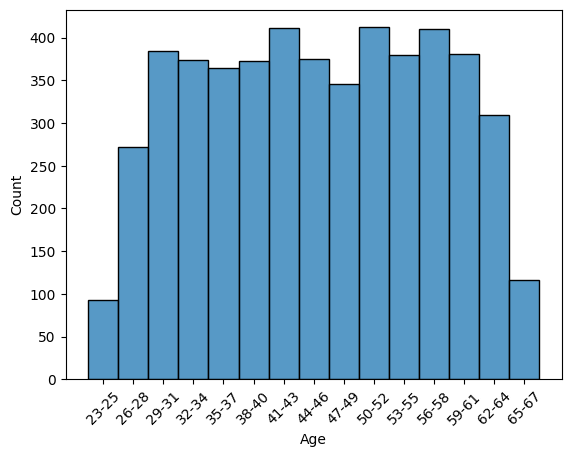

In [70]:
ax = sns.histplot(classes)
ax.tick_params(axis='x', labelrotation=45)

Agregando por intervalos, pode observar-se um maior número de pessoas entre os 30 e os 60 anos a tentar pedir empréstimos ao banco.

## Experience
A experiência é uma variável numérica de rácio, pois o 0 tem valor absoluto.

<Axes: xlabel='Experience', ylabel='Count'>

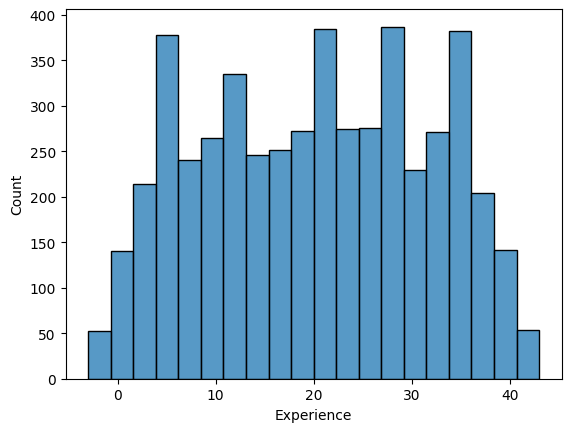

In [71]:
sns.histplot(df['Experience'])

In [72]:
df[df["Experience"] < 0]["Age"].quantile([0., .25,.5,.75, 1.])

0.00    23.0
0.25    24.0
0.50    24.0
0.75    25.0
1.00    29.0
Name: Age, dtype: float64

A experiência ser negativa pode ser porque:
* Após ser despedido, os anos que despendeu no trabalho são subtraídos à sua experiência de forma a indicar o despedimento, assim pessoas com anos de experiência negativos são aqueles que ou ainda não tinham experiência ou estão sempre a ser despedidos
* Tendo em conta que as idades das pessoas com experiência negativa são próximas dos 20 anos, pode-se interpretar os anos negativos sendo o tempo que falta para terminarem os estudos na universidade

In [73]:
print("Exp. mínima: ", df["Experience"].min())
print("Exp. máxima: ", df["Experience"].max())

Exp. mínima:  -3
Exp. máxima:  43


In [74]:
classes = pd.cut(df["Experience"], 15, labels=[
    "-3-(-1)", "0-2", "3-5", "6-8", "9-11", "12-14",
    "15-17", "18-20", "21-23", "24-26", "27-29", "30-32",
    "33-35", "36-38", "39+"])

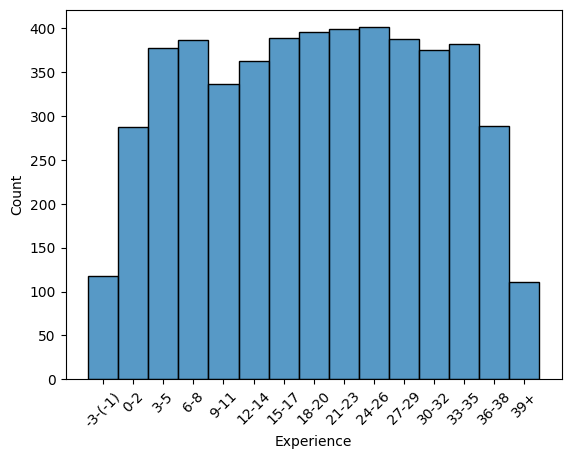

In [75]:
ax = sns.histplot(classes)
ax.tick_params(axis='x', labelrotation=45)

Quem pede mais empréstimos, assim como na idade, aqui são as pessoas que têm pouca experiência ou que têm já muita experiência, logo há um concentração maior entre adultos com pouca experiência e adultos próximos da terceira idade que procuram estabilizar-se na vida.

## Income
O salário é uma variável numérica de rácio, pois o 0 tem valor absoluto.

Text(0, 0.5, 'Frequência')

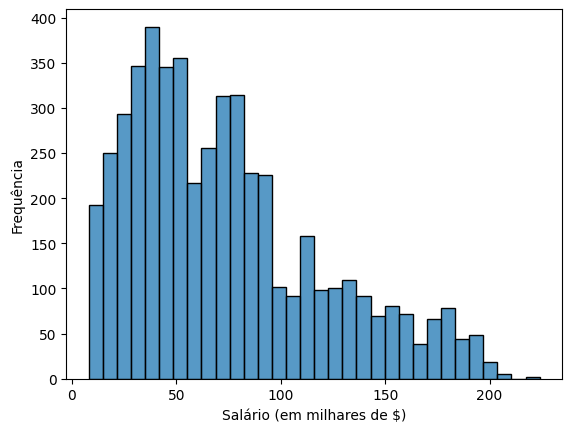

In [76]:
ax = sns.histplot(df['Income'])
ax.set_xlabel("Salário (em milhares de $)")
ax.set_ylabel("Frequência")

In [77]:
df['Income'].quantile([0., .25, .5, .75, 1.])

0.00      8.0
0.25     39.0
0.50     64.0
0.75     98.0
1.00    224.0
Name: Income, dtype: float64

Pode-se observar que os valores estão representados em milhares de dólares. Além disso, verifica-se que 75% da amostra recebe até 98 mil dólares por ano (~8000$ por mês). Os restantes 25% têm uma maior disparidade, alcançando os 224 mil dólares anuais.

## Zip Code
O código postal é uma variável numérica de rácio, pois o 0 tem valor absoluto.

In [78]:
counts = df["ZIP.Code"].value_counts()
counts

ZIP.Code
94720    169
94305    127
95616    116
90095     71
93106     57
        ... 
96145      1
94087      1
91024      1
9307       1
94598      1
Name: count, Length: 467, dtype: int64

In [79]:
# Obter JSON que converte ZIP Code em FIPS
url = "https://gist.githubusercontent.com/promptworks/5728784/raw/2ea5eb7f5e18e0f69ffa7df682b3793aad1382d2/zip2fips.json"
response = urlopen(url) 
data_json = json.loads(response.read())

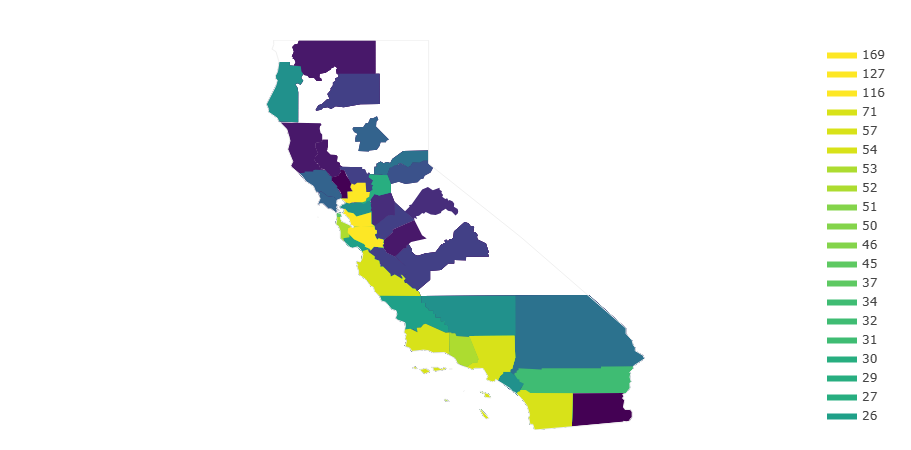

In [80]:
zips, cont = counts.index.tolist(), counts.values.tolist()

dict_zips = {k:v for k, v in zip(zips, cont)}

fips = list()

for z in zips:
    try:
        fip = int(data_json[str(z)][0])
        fips.append(fip)
    except KeyError as e:
        # Caso não encontre o FIP para o Zip Code remove-se
        dict_zips.pop(z)


fig = ff.create_choropleth(fips=fips, values=list(dict_zips.values()), scope=['CA'], show_state_data=True)
fig.layout.template = None
fig.show()

É são pedidos mais empréstimos Alameda, Santa Clara, Solano

Onde há menos empréstimos Napa, Imperial, Siskiyou

Para o ZIP Code ter mais significado, decidiu-se convertê-lo em latitude e longitude, criando assim 2 variáveis numéricas de intervalo.

Caso não seja possível a conversão, os NaNs serão substituídos pela média, para manter a distribuição dos dados.

In [81]:
nomi = pgeocode.Nominatim('us')

# Criar as colunas lat e long
for index, row in df.iterrows():
    coords = nomi.query_postal_code(int(row["ZIP.Code"]))
    #print(coords)
    df.at[index, "longitude"] = coords["longitude"]
    df.at[index, "latitude"] = coords["latitude"]


# Substituir valores em falta (NaN)
df["latitude"].fillna(df["latitude"].mean(), inplace=True)
df["longitude"].fillna(df["longitude"].mean(),  inplace=True)

In [82]:
# Elimina-se o código postal, pois já temos uma representação melhor dele
df.drop(columns=["ZIP.Code"], inplace=True)

## Agregado Familiar
O agregado familiar é uma variável numérica de rácio, pois o 0 tem valor absoluto.

<Axes: xlabel='Family', ylabel='Count'>

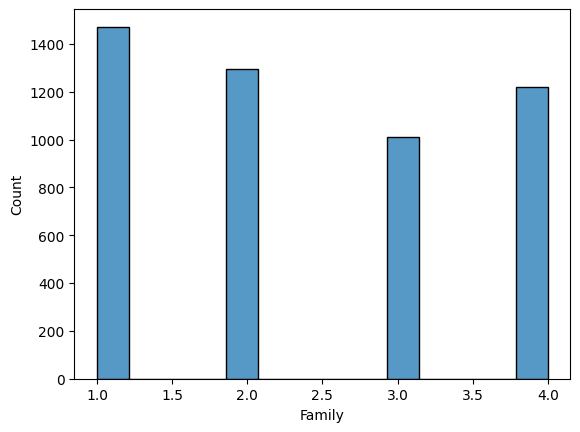

In [83]:
sns.histplot(df["Family"])

In [84]:
df['Family'].quantile([0., .25, .5, .75, 1.])

0.00    1.0
0.25    1.0
0.50    2.0
0.75    3.0
1.00    4.0
Name: Family, dtype: float64

Metade da amostra tem entre 1 a 2 familiares no seu agregado.

## Score Cartão de Crédito

<Axes: xlabel='CCAvg', ylabel='Count'>

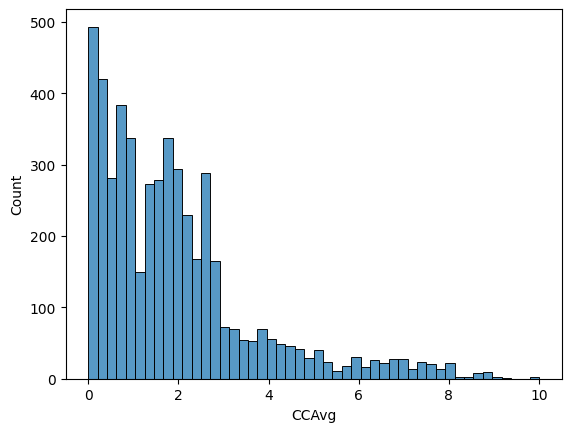

In [85]:
sns.histplot(df["CCAvg"])

In [86]:
df['CCAvg'].quantile([0., .25, .5, .75, 1.])

0.00     0.0
0.25     0.7
0.50     1.5
0.75     2.5
1.00    10.0
Name: CCAvg, dtype: float64

Há uma grande descrepância entre os 75% e os 100%, já que 75% tem um valor máximo de 2.5 e entre 75% e 100% atinge-se valores até 10.

## Escolaridade

<Axes: xlabel='Education', ylabel='Count'>

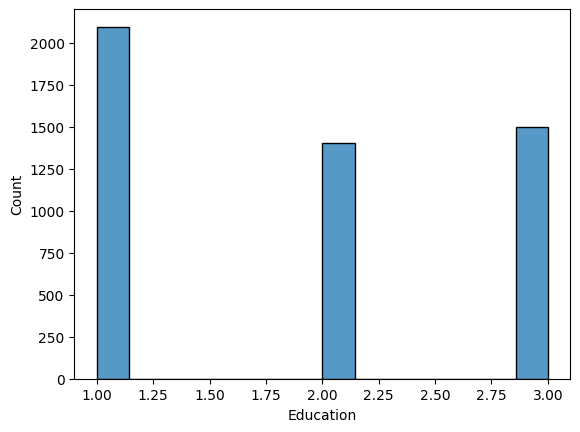

In [87]:
sns.histplot(df["Education"])

In [88]:
df['Education'].quantile([.25, .5, .75])

0.25    1.0
0.50    2.0
0.75    3.0
Name: Education, dtype: float64

Não há um significado claro para a quantificação desta variável, porém 50% tem no máximo 2, tendo uma quantidade superior em 1.

## Hipoteca

<Axes: xlabel='Mortgage', ylabel='Count'>

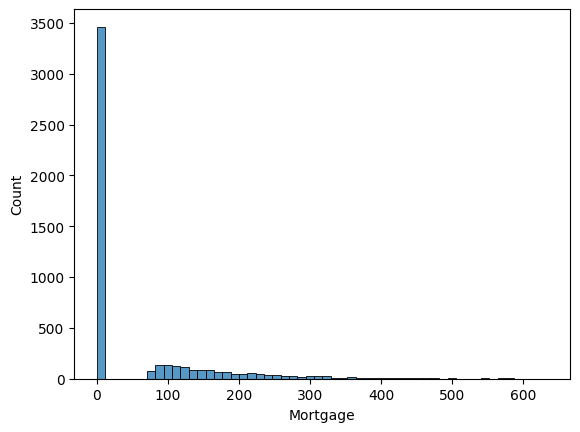

In [89]:
sns.histplot(df["Mortgage"])

In [90]:
df["Mortgage"].value_counts()

Mortgage
0      3462
98       17
119      16
89       16
91       16
       ... 
547       1
458       1
505       1
361       1
541       1
Name: count, Length: 347, dtype: int64

3462 pessoas não têm hipoteca, o que pode significar que o banco não sente necessidade de ter uma garantia OU não fez o empréstimo, logo não há hipoteca.

## Empréstimo

<Axes: xlabel='Personal.Loan', ylabel='Count'>

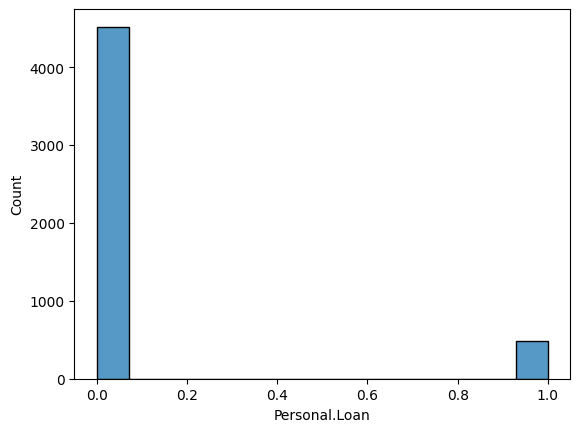

In [91]:
sns.histplot(df["Personal.Loan"])

In [92]:
df["Personal.Loan"].value_counts()

Personal.Loan
0    4520
1     480
Name: count, dtype: int64

90% da população não conseguiu empréstimo.

## Conta de Valores / Conta Poupança / Homebanking/ Cartão de Crédito

<Axes: xlabel='Securities.Account', ylabel='Count'>

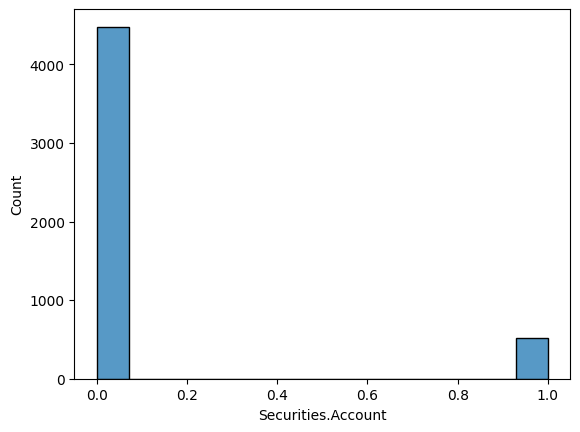

In [93]:
sns.histplot(df["Securities.Account"])

<Axes: xlabel='CD.Account', ylabel='Count'>

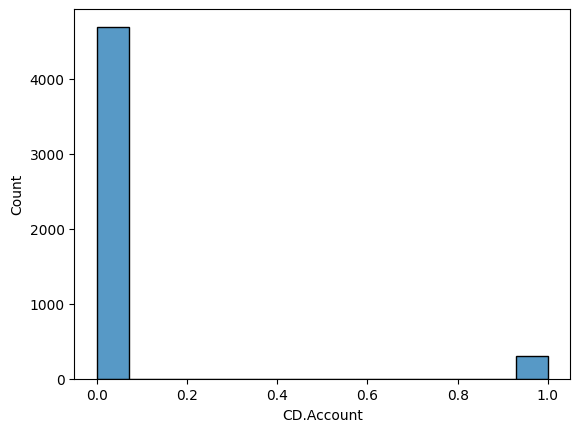

In [94]:
sns.histplot(df["CD.Account"])

<Axes: xlabel='Online', ylabel='Count'>

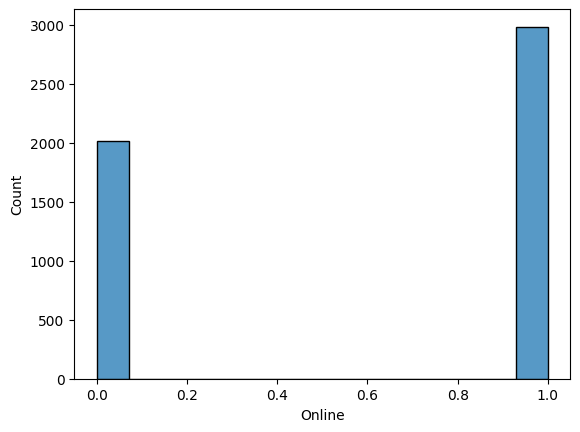

In [95]:
sns.histplot(df["Online"])

<Axes: xlabel='CreditCard', ylabel='Count'>

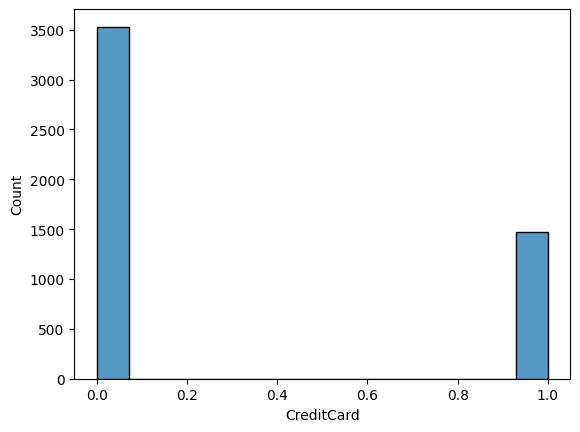

In [96]:
sns.histplot(df["CreditCard"])

90% não têm nem conta poupança nem conta de valores mobiliários. Mais de metade tem home banking e 70% não têm cartão de crédito. Provavelmente a maioria das pessoas da população não têm grandes posses.

# Análise Exploratória Multivariável

Para verificar a correlação linear entre as variáveis começaremos por aquelas que são contínuas (numéricas), aplicando a correlação de Pearson. Porém primeiro vamos standardizar os dados.

array([[<Axes: xlabel='Age', ylabel='Age'>,
        <Axes: xlabel='Experience', ylabel='Age'>,
        <Axes: xlabel='Income', ylabel='Age'>,
        <Axes: xlabel='CCAvg', ylabel='Age'>,
        <Axes: xlabel='Mortgage', ylabel='Age'>,
        <Axes: xlabel='latitude', ylabel='Age'>,
        <Axes: xlabel='longitude', ylabel='Age'>],
       [<Axes: xlabel='Age', ylabel='Experience'>,
        <Axes: xlabel='Experience', ylabel='Experience'>,
        <Axes: xlabel='Income', ylabel='Experience'>,
        <Axes: xlabel='CCAvg', ylabel='Experience'>,
        <Axes: xlabel='Mortgage', ylabel='Experience'>,
        <Axes: xlabel='latitude', ylabel='Experience'>,
        <Axes: xlabel='longitude', ylabel='Experience'>],
       [<Axes: xlabel='Age', ylabel='Income'>,
        <Axes: xlabel='Experience', ylabel='Income'>,
        <Axes: xlabel='Income', ylabel='Income'>,
        <Axes: xlabel='CCAvg', ylabel='Income'>,
        <Axes: xlabel='Mortgage', ylabel='Income'>,
        <Axes: xlabel='la

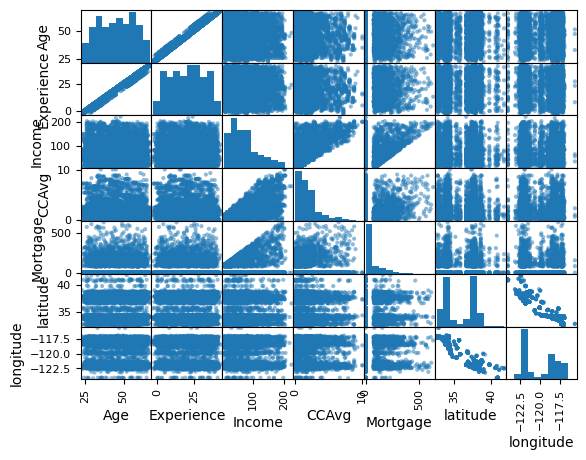

In [97]:
pd.plotting.scatter_matrix(df[["Age", "Experience", "Income", "CCAvg", "Mortgage", "latitude", "longitude"]])

Para analisar variáveis categóricas vamos utilizar o gráfico de violino de forma a observar-se a tendência e variabilidade dos valores.

<Axes: xlabel='Education', ylabel='CCAvg'>

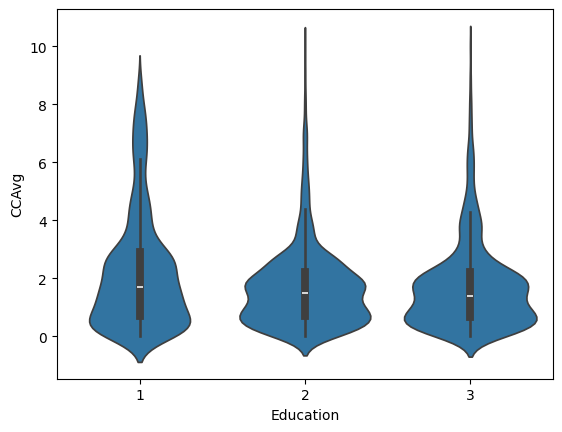

In [98]:
sns.violinplot(df, x="Education", y="CCAvg")

2 e 3 na educação têm grande concentração de dados entre 1 e 2 de CCAvg. Enquanto que Educação 1 tem maior concentração em 0 e 1, porém tem mais valores entre 4 e 8 CCAvg do que os outros dois.

<Axes: xlabel='Education', ylabel='Mortgage'>

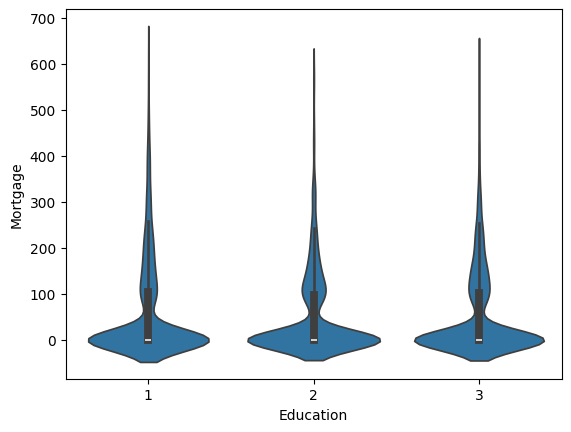

In [99]:
sns.violinplot(df, x="Education", y="Mortgage")

A maioria não paga hipoteca, e os que pagam têm nível 2 ou 3 de escolaridade.

<Axes: xlabel='Education', ylabel='Age'>

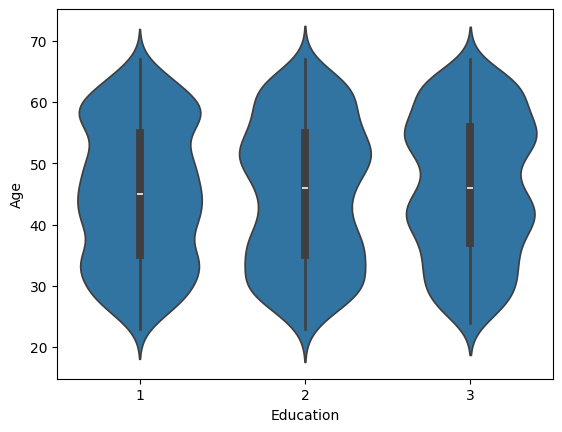

In [100]:
sns.violinplot(df, x="Education", y="Age")

Pessoas mais velhas tendem a ter escolaridade nível 3 e pessoas mais novas (até aos 35 anos) têm uma escolariade 1 ou 2, o que pode significar que escolaridade 1 é Prosseguimento de Estudos enquanto 3 poderá ser apenas até a um certo ano de escolaridade.

<Axes: xlabel='Education', ylabel='Experience'>

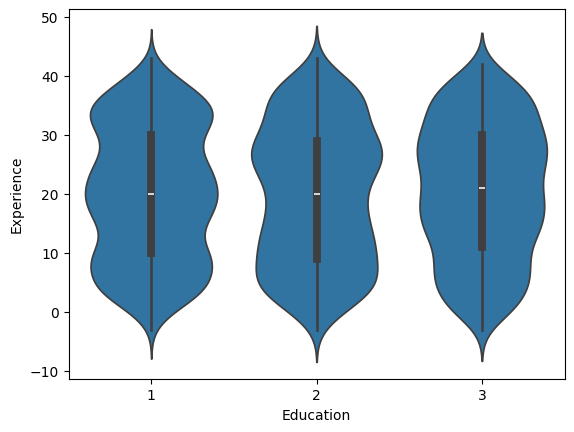

In [101]:
sns.violinplot(df, x="Education", y="Experience")

Pessoas com escolaridade 3 tendem a ter uma maior diversidade de anos de experiência

<Axes: xlabel='Education', ylabel='Income'>

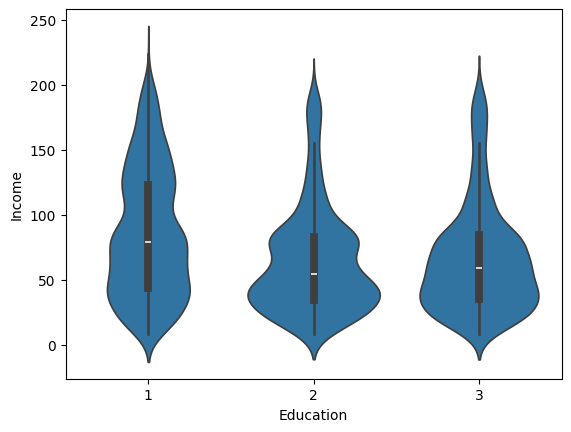

In [102]:
sns.violinplot(df, x="Education", y="Income")

Quem tem escolaridade nível 1 tem salários anuais maiores. Os restantes tendem a ter algo até 50 mil dólares por ano. Há uma maior estabilidade de valores entre 50 e 100 mil para a escolaridade 3, podendo ser por causa da idade avançada das pessoas que têm este grau de escolaridade, pois podem ter negócios de família ou algo do género.

<Axes: xlabel='Education', ylabel='latitude'>

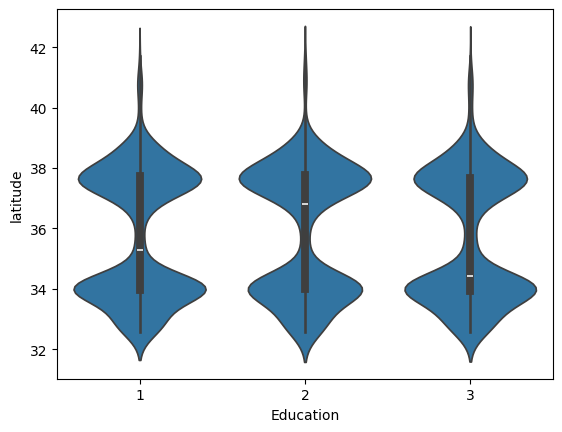

In [103]:
sns.violinplot(df, x="Education", y="latitude")

<Axes: xlabel='Education', ylabel='longitude'>

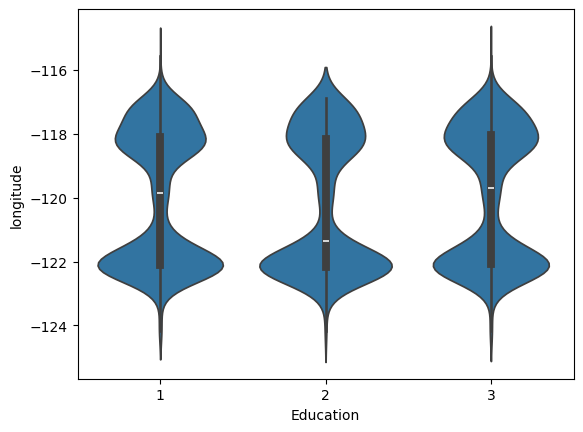

In [104]:
sns.violinplot(df, x="Education", y="longitude")

A única diferença entre os diversos níveis de escolaridade e latitude/longitude é a densidade dos dados que estão mais no nível 1, pois há um maior número de registos com esse nível.

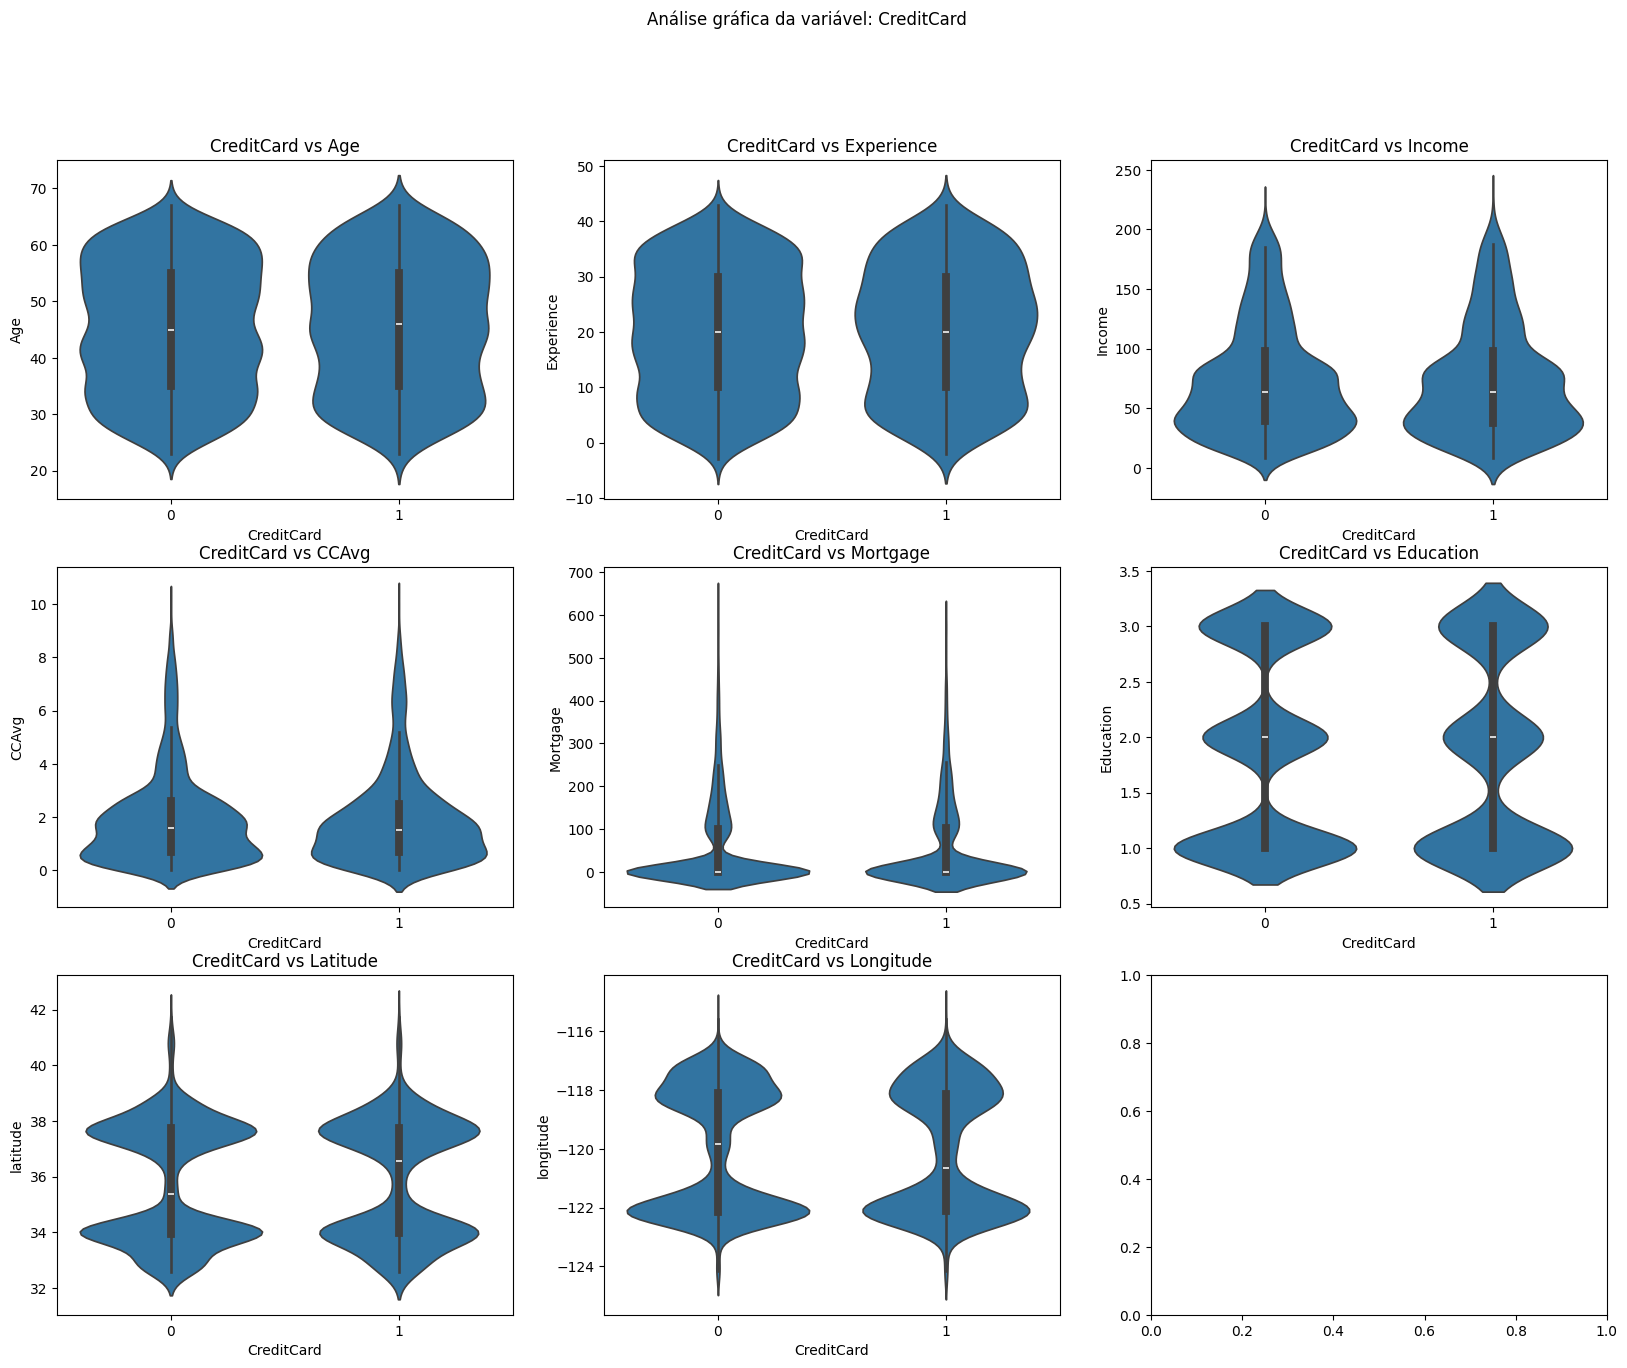

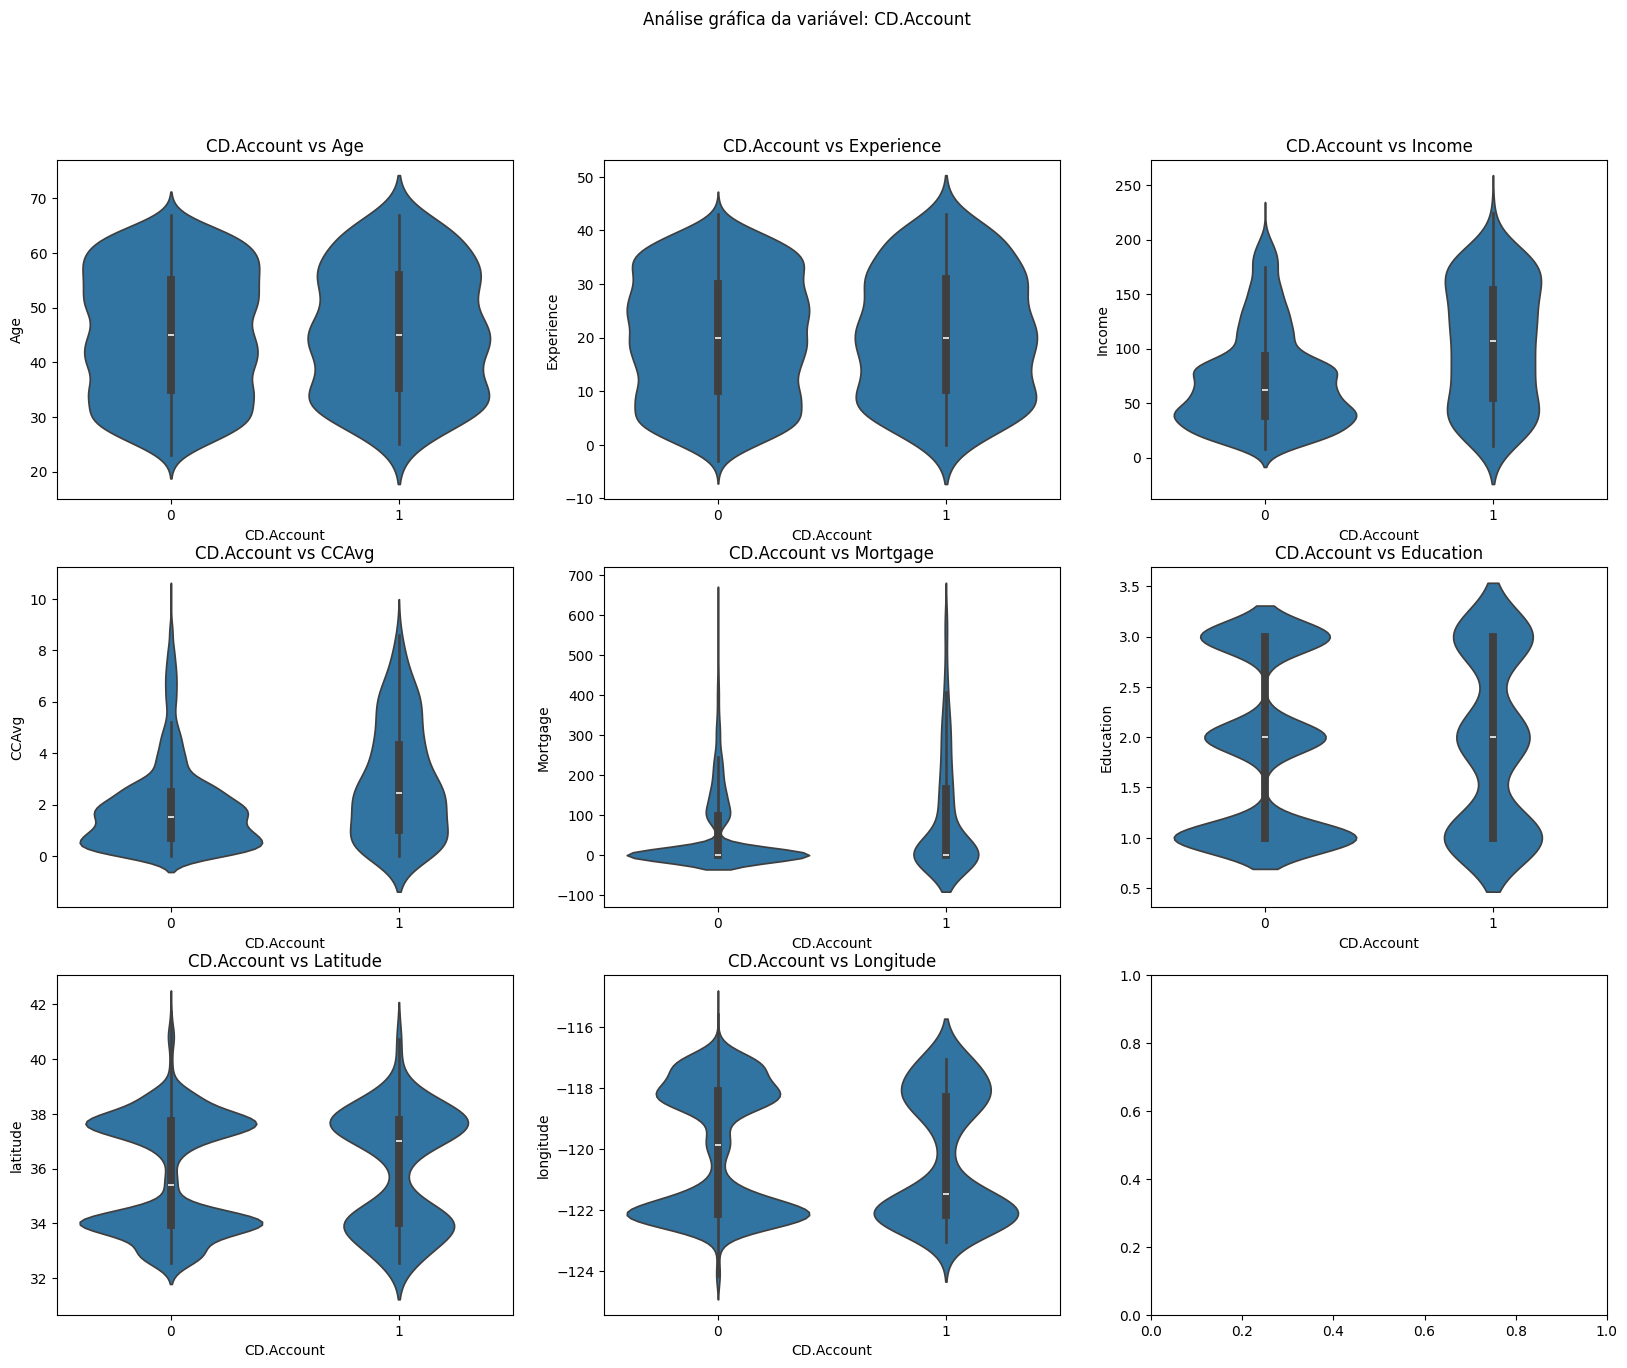

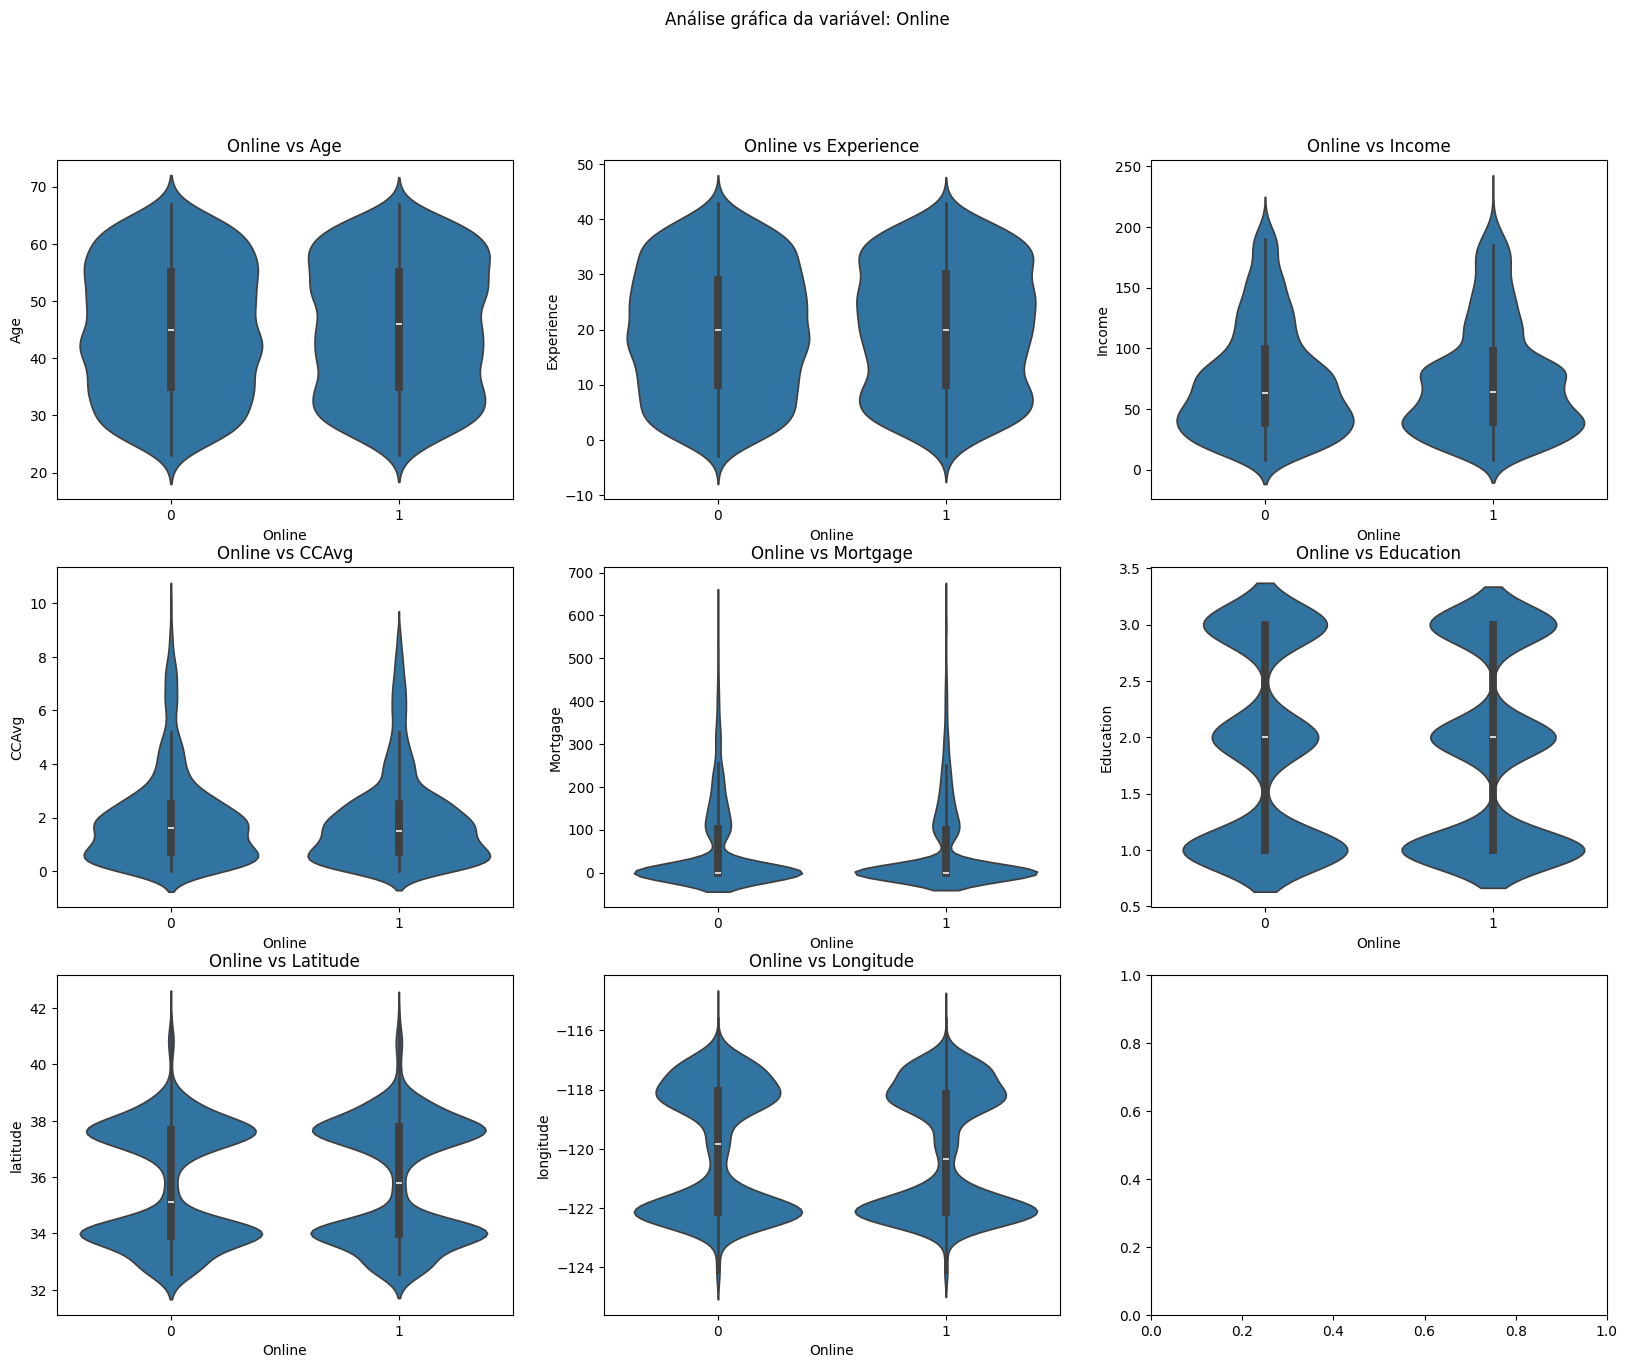

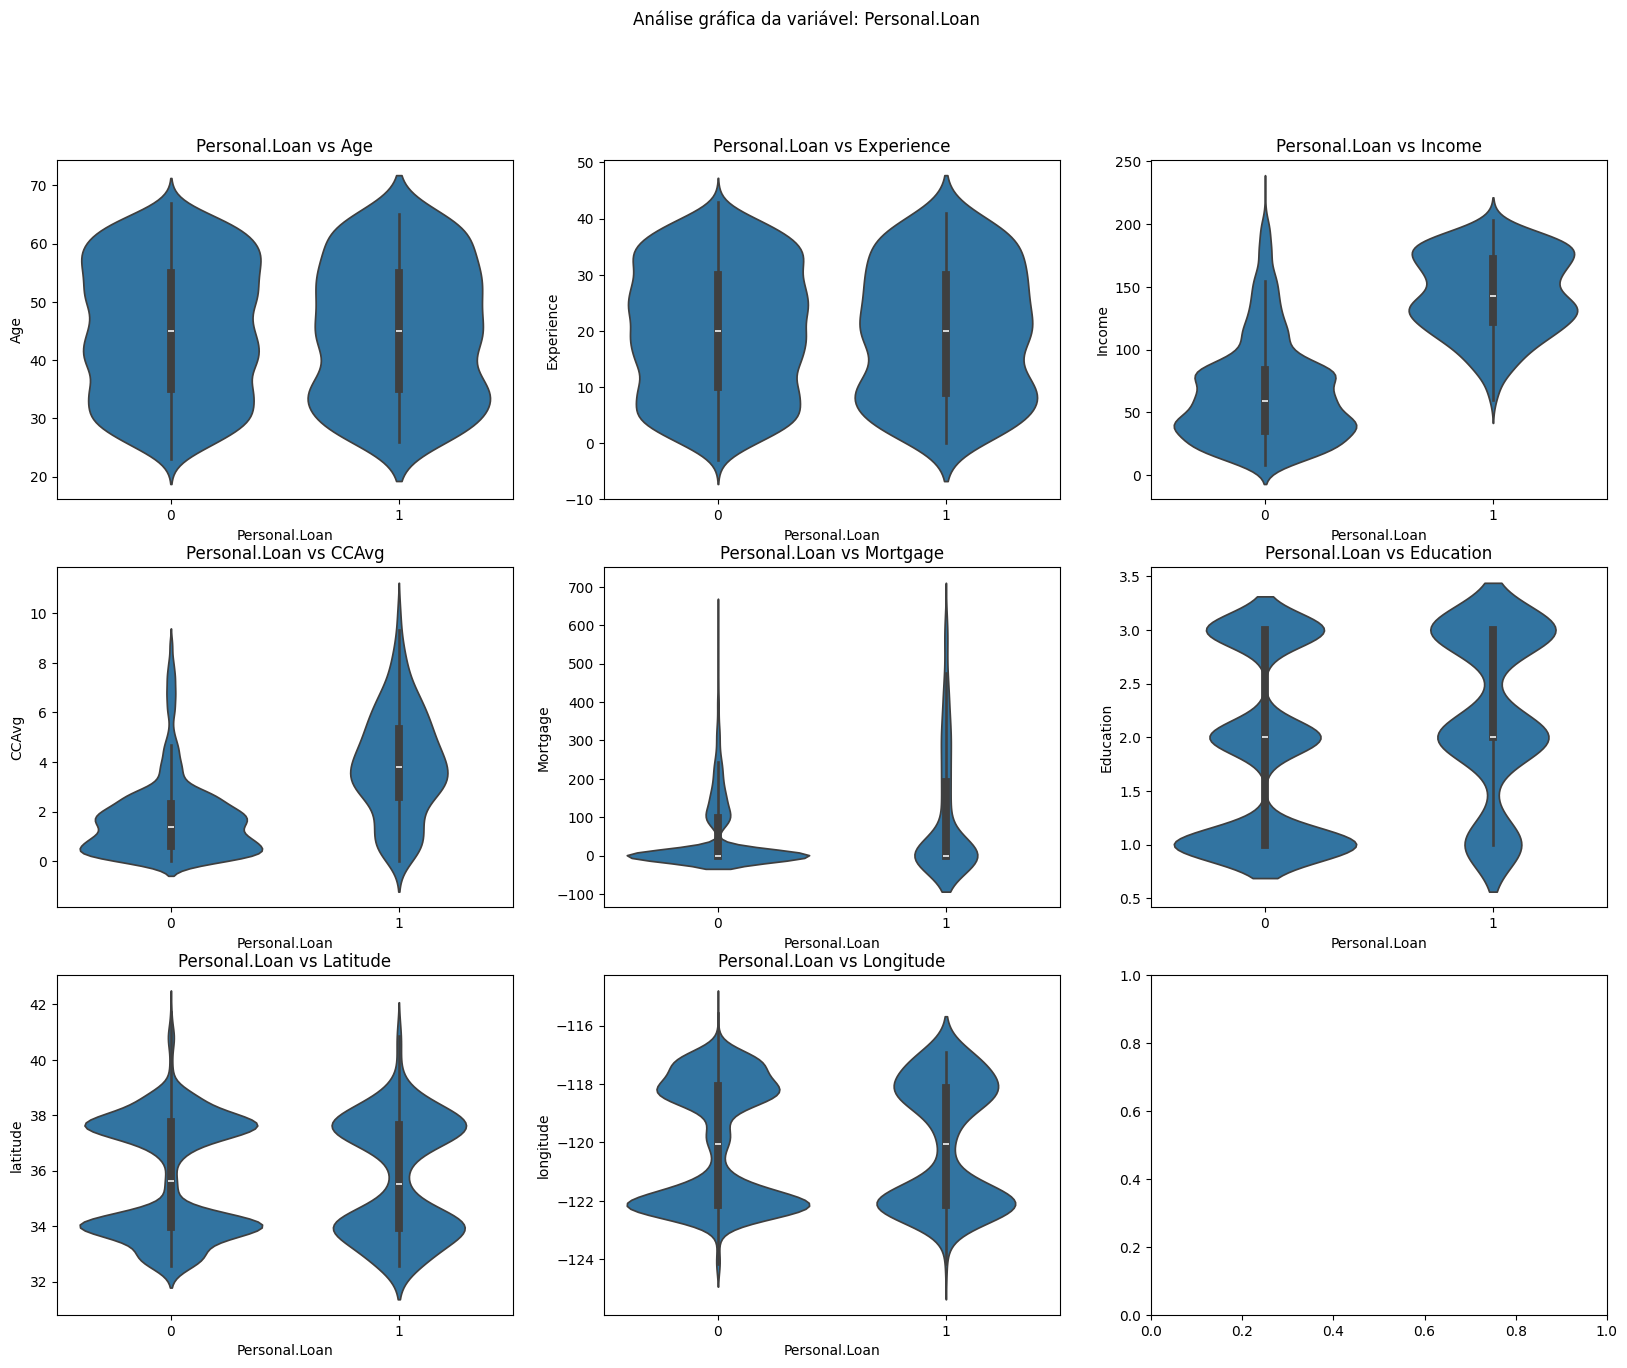

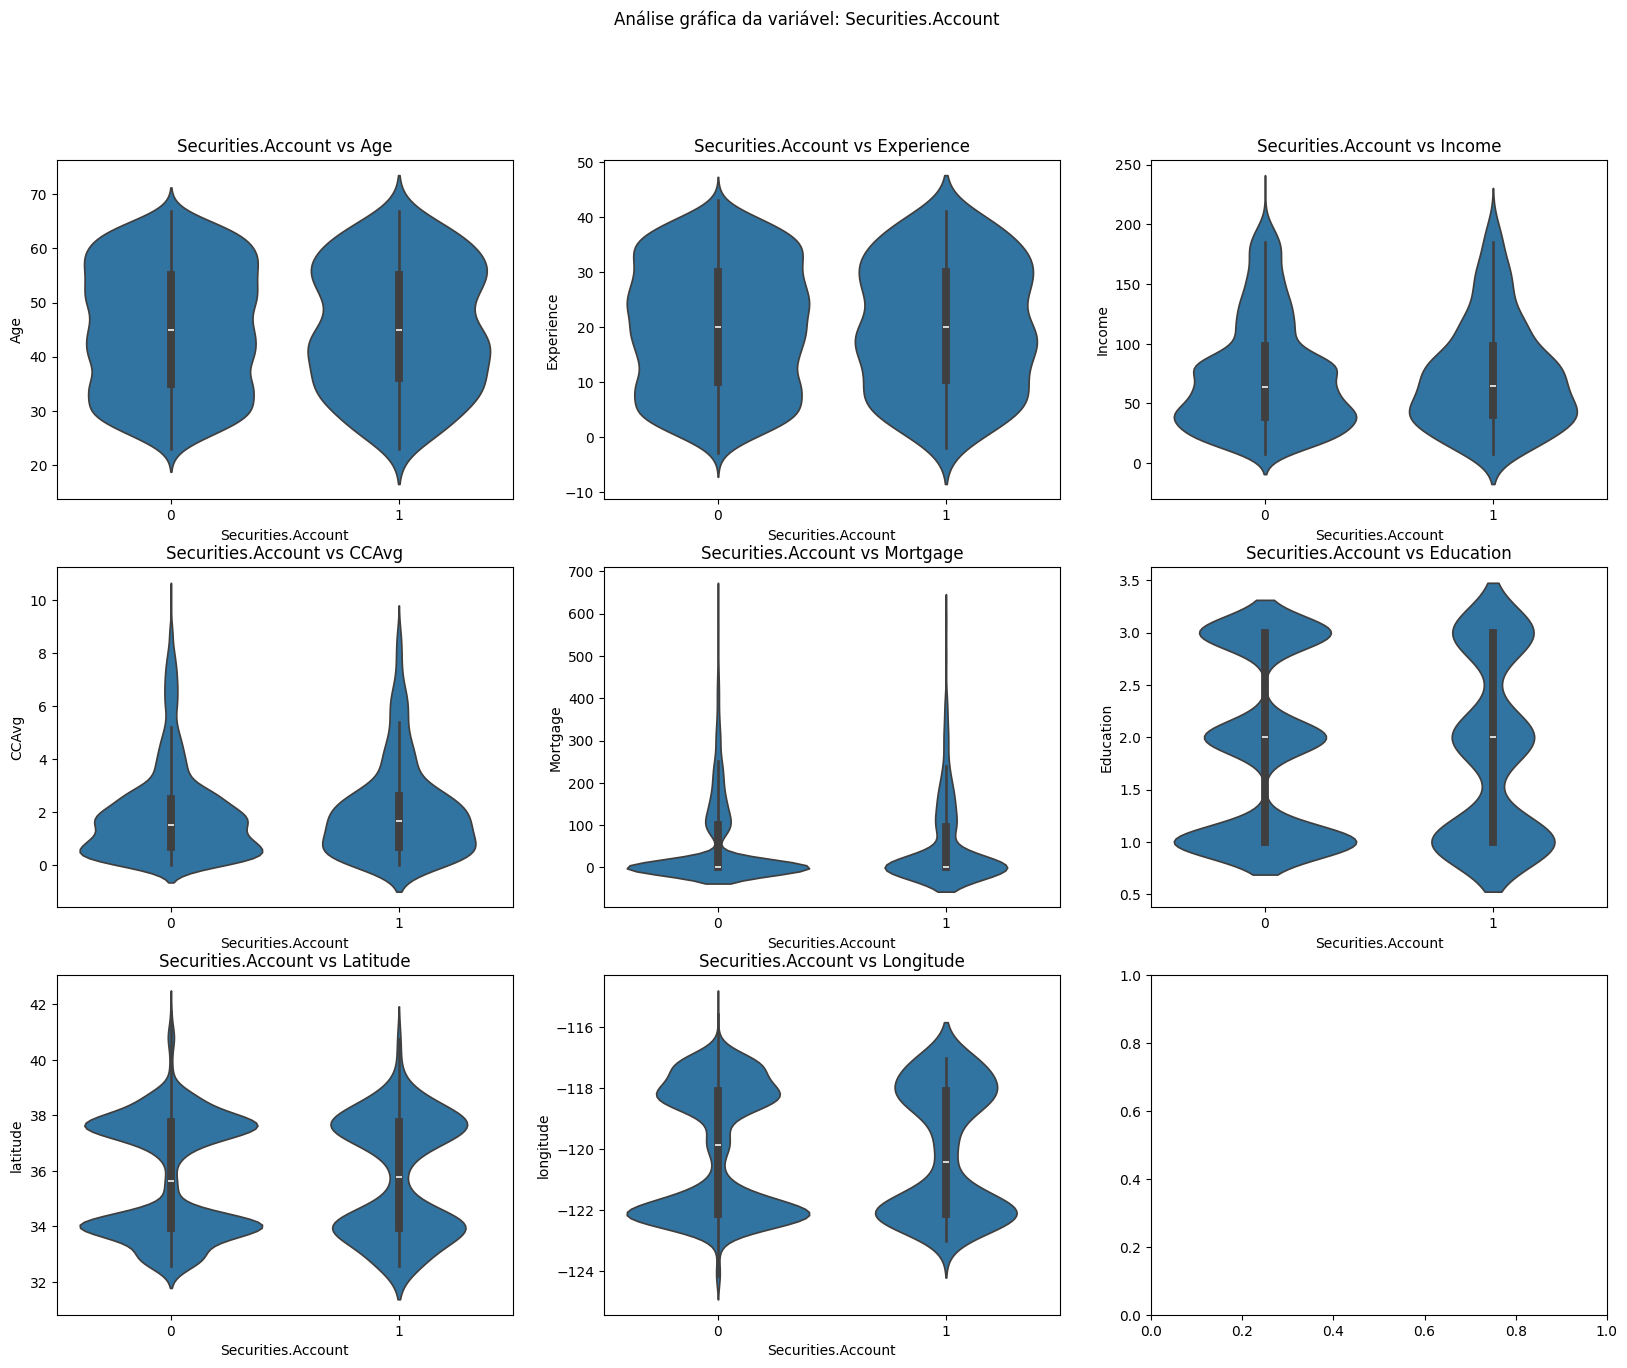

In [105]:
# Analisar dicotomicas com numéricas e ordinais
dicotomicas = {"Personal.Loan", "Securities.Account", "CD.Account", "Online", "CreditCard"}

for dico in dicotomicas:
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    fig.suptitle('Análise gráfica da variável: ' + dico)
    
    sns.violinplot(ax=axes[0][0], x=df[dico], y=df["Age"])
    axes[0][0].set_title(dico + " vs Age")
    
    sns.violinplot(ax=axes[0][1], x=df[dico], y=df["Experience"])
    axes[0][1].set_title(dico + " vs Experience")
    
    sns.violinplot(ax=axes[0][2], x=df[dico], y=df["Income"])
    axes[0][2].set_title(dico + " vs Income")
    
    sns.violinplot(ax=axes[1][0], x=df[dico], y=df["CCAvg"])
    axes[1][0].set_title(dico + " vs CCAvg")
    
    sns.violinplot(ax=axes[1][1], x=df[dico], y=df["Mortgage"])
    axes[1][1].set_title(dico + " vs Mortgage")

    sns.violinplot(ax=axes[1][2], x=df[dico], y=df["Education"])
    axes[1][2].set_title(dico + " vs Education")

    sns.violinplot(ax=axes[2][0], x=df[dico], y=df["latitude"])
    axes[2][0].set_title(dico + " vs Latitude")

    sns.violinplot(ax=axes[2][1], x=df[dico], y=df["longitude"])
    axes[2][1].set_title(dico + " vs Longitude")

### Cartão de Crédito vs Variáveis numéricas e ordinais
Quem tem cartão de crédito tende a ter uma nível de escolaridade 1 (mais alto) . Também há uma maior diversidade no score do cartão de crédito para quem o tem. Há muito mais gente sem cartão de crédito que não paga hipoteca.

### Home Banking vs Variáveis numéricas e ordinais
Os gráficos parecem idênticos, havendo apenas um pouco mais de concentração de pessoas com home banking que têm nível 1 de educação

### Conta de valores vs Variáveis numéricas e ordinais
A maioria que não tem este tipo de conta não paga hipoteca e tende a ter um nível de escolaridade 1.

### Conta poupança vs Variáveis numéricas e ordinais
Aqui também verifica-se que quem não tem este tipo de conta não paga hipoteca e tem uma escolaridade de nível 1. Porém tambéms se destaca o score do cartão de crédito de quem tem este tipo de conta é mais disperso, enquanto quem não tem tem scores próximos de 0. 

### Empréstimo vs Variáveis numéricas e ordinais
O salário é mais elevado para quem obteve o empréstimo, o que é expectável, porque quanto maior os rendimentos maior a probabilidade de se obter um empréstimo. Quem obteve empréstimo também não paga hipoteca, ou paga um valor até 100 mil dólares, devido aos elevados rendimentos e têm um score de cartão de crédito muito disperso. A escolaridade de quem obtém estes empréstimos é nível 3, podendo ser por causa de ser pessoas com maior idade e que não prosseguiu os estudos.

In [106]:
# Standardization (menos das variáveis dicotómicas)
cols = set(df.columns) - {"Personal.Loan", "Securities.Account", "CD.Account", "Online", "CreditCard"}

df_std = df.copy()

for col in cols:
    df_std[col] = (df_std[col] - df_std[col].mean()) / df_std[col].std() 

# Correlação de Pearson
df_std[["Age", "Experience", "Income", "CCAvg", "Mortgage", "latitude", "longitude"]].corr()

Age  Experience    Income     CCAvg  Mortgage  latitude  \
Age         1.000000    0.994215 -0.055269 -0.052012 -0.012539 -0.023871   
Experience  0.994215    1.000000 -0.046574 -0.050077 -0.010582 -0.024146   
Income     -0.055269   -0.046574  1.000000  0.645984  0.206806 -0.024984   
CCAvg      -0.052012   -0.050077  0.645984  1.000000  0.109905 -0.013286   
Mortgage   -0.012539   -0.010582  0.206806  0.109905  1.000000 -0.002767   
latitude   -0.023871   -0.024146 -0.024984 -0.013286 -0.002767  1.000000   
longitude   0.018984    0.019341  0.016330  0.005025  0.003879 -0.950253   

            longitude  
Age          0.018984  
Experience   0.019341  
Income       0.016330  
CCAvg        0.005025  
Mortgage     0.003879  
latitude    -0.950253  
longitude    1.000000

### Correlações Positivas
CCAvg <-> Income

Mortgage <-> Income (correlação baixa)

Experience <-> Age (quase perfeitamente correlacionada)

### Correlações Negativas
Latitude <-> Longitude

Para verificar a correlação entre variáveis categóricas ordinais e numéricas, utiliza-se a correlação de Spearman, pois esta vai medir a correlação entre cada possível valor ordinal (rank) e os valores contínuos da variável numérica. 

In [107]:
baffles = df_std["Education"].to_numpy()
cols = set(df_std.columns) - {"Education", "Personal.Loan", "Securities.Account", "CD.Account", "Online", "CreditCard", "ID"}

data = dict()

for col in cols:
    data[col] = [df_std["Education"].corr(df_std[col], method="spearman"), ]

df_data = pd.DataFrame(data, index=["Education", ])

df_data

latitude    Family  longitude    Income  Mortgage  Experience  \
Education -0.012673  0.068676   0.004613 -0.183439 -0.011933    0.012994   

                Age     CCAvg  
Education  0.039845 -0.099144

### Correlações Negativas
A única correlação da escolaridade é com o salário, em que à medida que o número da coluna `Education` aumenta, o `Income` diminui, ou seja, possivelmente 1 de educação é melhor do que 2 ou 3.

Para calcular as correlações entre variáveis dicotómicas e numéricas ou até ambas dicotómicas, utiliza-se o ponto bisserial.

In [108]:
dicotomicas = {"Personal.Loan", "Securities.Account", "CD.Account", "Online", "CreditCard"}

for dico in dicotomicas:
    cols = set(df_std.columns) - {dico, "ID"}
    data = dict()    
    
    for col in cols:
        data[col] = [pointbiserialr(df_std[dico].to_numpy(), df_std[col].to_numpy()).statistic, ]
    
    df_data = pd.DataFrame(data, index=[dico, ])
    
    display(df_data)

latitude    Family  longitude  CD.Account   Online  Personal.Loan  \
CreditCard   0.01558  0.011588  -0.021011    0.278644  0.00421       0.002802   

            Securities.Account    Income  Mortgage  Experience       Age  \
CreditCard           -0.015028 -0.002385 -0.007231    0.008967  0.007681   

            Education     CCAvg  
CreditCard  -0.011014 -0.006689

latitude   Family  longitude   Online  Personal.Loan  \
CD.Account  0.024173  0.01411  -0.029236  0.17588       0.316355   

            Securities.Account    Income  Mortgage  CreditCard  Experience  \
CD.Account            0.317034  0.169738  0.089311    0.278644    0.010353   

                 Age  Education     CCAvg  
CD.Account  0.008043   0.013934  0.136534

latitude    Family  longitude  CD.Account  Personal.Loan  \
Online  0.030899  0.010354  -0.018901     0.17588       0.006278   

        Securities.Account    Income  Mortgage  CreditCard  Experience  \
Online            0.012627  0.014206 -0.005995     0.00421    0.013898   

             Age  Education     CCAvg  
Online  0.013702  -0.015004 -0.003611

latitude    Family  longitude  CD.Account    Online  \
Personal.Loan -0.005932  0.061367  -0.002006    0.316355  0.006278   

               Securities.Account    Income  Mortgage  CreditCard  Experience  \
Personal.Loan            0.021954  0.502462  0.142095    0.002802   -0.007413   

                    Age  Education     CCAvg  
Personal.Loan -0.007726   0.136722  0.366889

latitude    Family  longitude  CD.Account    Online  \
Securities.Account -0.000582  0.019994  -0.004198    0.317034  0.012627   

                    Personal.Loan    Income  Mortgage  CreditCard  Experience  \
Securities.Account       0.021954 -0.002616 -0.005411   -0.015028   -0.001232   

                         Age  Education     CCAvg  
Securities.Account -0.000436  -0.010812  0.015086

### Correlações positivas
`CrediCard`, `Online` e `Securities.Account` têm uma correlação positiva com `CDAccount`, ou seja, quando se tem um dos 3, tem-se uma conta de valores mobiliários. 

`CDAccount` acaba por ter uma correlação positiva fraca com o `Income`. 

`Personal.Loan`, atributo alvo, tem correlação com `Income`, `CD.Account` e `CCAvg`, o que significa que quanto maior os valores nestas variáveis, maior a probabilidade de se obter um empréstimo.

# Redução de dimensionalidade

Não há necessidade de pré-processamento dos dados, já que não há valores em falta nem variáveis com valores que não sejam inteiros ou floats. A standardização já fora feita, exceto para as variáveis dicotómicas que não devem ser standardizadas, antes da execução das correlações.

Aqui vai-se utilizar um método Wrapper para seleção os atríbutos que melhor representam a amostra e que permitem uma melhor estimativa do atributo alvo. 

## Seleção de atributos considerando o atributo alvo para classificação
Considerando que é um problema de classificação, pode-se utilizar uma regressão logística, já que esta não tem hiperparâmetros para se testar.

Considerando que temos 11 atributos, já que o `ID` só serve como identificador de registos e tanto a `latitude` como a `longitude` não mostrou qualquer relação entre os demais atributos preditivos e o próprio atributo alvo. E retira-se o atributo alvo `Personal.Loan`. 

Havendo pelo menos 3 métodos para aplicar o Wrapper como seleção de atríbutos:
* Seleção de atributos para a frente (forward)
* Seleção de atributos para a trás (backwards)
* seleção de atributos exaustiva

A exaustiva é a mais completa, porém a que exige mais poder computacional, logo mais tempo. Para haver alguma exatidão, ele vai calcular todos os possíveis subconjuntos de 1, ..., 11 atributos, ou seja, tem-se as seguintes combinações:
* $C_1 = {11 \choose 1} = 11$
* $C_2 = {11 \choose 2} = 55$
* ...
* $C_{11} = {11 \choose 11} = 1$

Sendo assim a soma de todas as combinações dá $2047$ combinações que terão de ser testadas.

Para reduzir este valor para algumas dezenas de combinações, bastava obter os 5 melhores atributos com a seleção para a frente, dessa forma obter-se um total de $31$ combinações quando se for executar a seleção exaustiva e após alguns testes verificámos que mesmo com 31 combinações, mantendo o mesmos k-folds e métrica, demora um certo tempo e no fim mantém o exato mesmo subconjunto selecionado pela seleção para a frente (sendo esta mais rápida).

Por isso irá-se usar esta seleção mais rápida e escolher o subconjunto com menor número de atributos mas que mantêm uma classificação muito próxima da melhor (com apenas 1 desvio-padrão de diferença), utilizando `k_features="parsimonious"`.

In [117]:
df_filtrado = df_std.drop(columns=["ID", "latitude", "longitude"])

In [110]:
X_cls, y_cls = df_filtrado.drop(columns=["Personal.Loan"]), df_filtrado["Personal.Loan"]

O ideal seria utilizar o Leave One Out para haver muitos registos para treinar, porém ter 5000 folds e repetir esse treino por 31 vezes é algo demorado e tem um custo computacional alto. Por isso, como está-se apenas a selecionar atributos, irá-se utilizar o k-fold mais comum, k = 10. 
Como a classificação é binária, pode-se avaliar o modelo utilizando o F1-Score para retirar-se vantagem do precision e recall para medir o rácio de falsos positivos e negativos.

In [78]:
for classifier in [LogisticRegression, DecisionTreeClassifier]:
    print(classifier.__name__)
    sfs_cls = SequentialFeatureSelector(classifier(random_state=SEED),
                                    k_features="parsimonious", 
                                    scoring='f1', 
                                    cv=10)  
    sfs_cls.fit(X_cls, y_cls)
    print("Avg F1-Score: ", sfs_cls.subsets_[len(sfs_cls.k_feature_names_)]["avg_score"])
    print("Atributos selecionados:", end=" ")
    print(sfs_cls.k_feature_names_)

LogisticRegression
Avg F1-Score:  0.7046520854087538
Atributos selecionados: ('Income', 'Family', 'Education', 'Securities.Account', 'CD.Account', 'CreditCard')
DecisionTreeClassifier
Avg F1-Score:  0.9191017320356663
Atributos selecionados: ('Age', 'Income', 'Family', 'CCAvg', 'Education', 'Mortgage')


## Seleção de atributos considerando o atributo alvo para regressão

Aqui usar-se-á a mesma técnica apenas troca-se o atributo alvo. No entanto, a regressão logística não poderá ser utilizada, porque não é um algoritmo de regressào (apesar do nome), assim como a métrica terá que ser outra.

A métrica mais comum é o Coeficiente de Determinação ($R^2$) variando, continuamente, entre $[0,1]$, e será esta utilizada.

Testar-se-á 2 algoritmos diferentes para comparar-se os atributos obtidos e o $R^2$ de cada.

In [111]:
# Standardizar tudo menos variáveis dicotómicas e o atributo alvo (Income)
cols = set(df.columns) - {"Personal.Loan", "Securities.Account", "CD.Account", "Online", "CreditCard", "Income"}

df_std_reg = df.copy()

for col in cols:
    df_std_reg[col] = (df_std_reg[col] - df_std_reg[col].mean()) / df_std_reg[col].std() 

df_filtrado_reg = df_std_reg.drop(columns=["ID", "latitude", "longitude"])

In [112]:
X_lin, y_lin = df_filtrado_reg.drop(columns=["Income"]), df_filtrado_reg["Income"]

In [82]:
for regressor in [LinearRegression, DecisionTreeRegressor]:
    print(regressor.__name__)
    sfs_reg = SequentialFeatureSelector(regressor(),
                                    k_features="parsimonious", 
                                    scoring='r2', 
                                    cv=10)  
    sfs_reg.fit(X_lin, y_lin)
    print("Avg R^2: ", sfs_reg.subsets_[len(sfs_reg.k_feature_names_)]["avg_score"])
    print("Atributos selecionados:", end=" ")
    print(sfs_reg.k_feature_names_)

LinearRegression
Avg R^2:  0.5435208203695491
Atributos selecionados: ('Family', 'CCAvg', 'Education', 'Mortgage', 'Personal.Loan')
DecisionTreeRegressor
Avg R^2:  0.7753484235102968
Atributos selecionados: ('Age', 'Family', 'CCAvg', 'Education', 'Personal.Loan')


Entre os atributos selecionados para classificação e regressão observa-se que a seleção por árvore de decisão apresenta melhores resultados, podendo ser devido à facilidade de agrupar intervalos de valores pelos diversos atriutos e que de certa forma separam tipos de registos, pois as árvores de decisão criam regras de associação, considerando diversos atributos, através de uma árvore binária.

Os atributos que mais aparecem são: `Family`, `Education`, `Income`, `Personal.Loan` e `CCAvg`


# Seleção do algoritmo de Classificação

Tendo os atributos selecionados e definidos os atributos alvos, serão testados 3 algoritmos de classificação:
* Support Vector Machine (SVM)
* Random Forests
* XGBoost


O SVM faz uso de uma matriz de transformação (kernel) que traça uma fronteira entre as várias dimensões, separando os registos de uma classe de outra. A fronteira é traçada com base nos vetores de suporte que são traçados em cima do(s) registo(s) mais próxima da possível fronteira (pelo menos um registo por classe). O kernel pode ser linear, criando assim um hiper plano ou pode ser não linear criando uma superfície cruva, sendo assim a fronteira.

Também tem hiperparâmetros que permitem deixar a fronteira muito restrita ou mais suave, deixando passar alguns registos mal classificados.


As florestas aleatórias são conjuntos de árvores de decisão que são avaliadas e utilizadas como um modelo Ensemble, isto é, um modelo que é compostos por vários classificadores e que classifica com base no resultado mais obtido ou a média dos resultados dos vários classificadores. Este faz uso do treino por boostraping treinando os múltiplos classificadores com dados de treino repetidos e usa os que nunca foram selecionados para teste. É um bom classificador para evitar overfitting, devido ao boostrapping diminuir a variabilidade. O hiperparâmetro aqui é o número de árvores de decisão


O XGBoost é também uma floresta de árvores de decisão, porém utiliza boosting, isto é, em vez de usar treinos paralelos de diferentes árvores de decisão, faz um treino sequencial, onde os registos que foram mal classificados na árvore anterior terão mais peso na próxima árvore, otimizando assim os resultados. O hiperparâmetro aqui é o número de árvores de decisão e o learning rate, já que este usa Gradient Boosting e tem de minimizar o erro dos classificadores.

Para decidir a melhor combinação de estes hiperparâmetros utilizar-se-á uma procura exaustiva (GridSearch) e como utilizar o Leave One Out num dataset com 5000 registos é algo que requer tempo e poder computacional, usar-se-á um Bootstrap Cross Validation que permite dados de treino repetidos e os restantes usam-se para teste, com 63% dados para treino.

In [113]:
# Dataset só com os atributos selecionados + o atributo alvo
dataset_filtrado = df_filtrado[list(sfs_cls.k_feature_names_) + ["Personal.Loan"]]
dataset_filtrado

NameError: name 'sfs_cls' is not defined

In [84]:
def boostraping(num_rep, estimator, dataset, target, metric):
    train_scores = list()
    test_scores = list()
    model = estimator
    
    for _ in range(num_rep):
        # Iniciar sempre um novo objeto
        model = clone(estimator)
        
        train = resample(dataset, n_samples=len(dataset), random_state=SEED)
        test = dataset[~dataset.index.isin(train.index)].dropna()
    
        X_train, y_train = train.drop(columns=[target]), train[target]
        X_test, y_test =  test.drop(columns=[target]), test[target]
        model.fit(X_train, y_train)

        train_scores.append(metric(y_train, model.predict(X_train)))
        test_scores.append(metric(y_test, model.predict(X_test)))
    
    return (train_scores , test_scores )

XGBClassifier {'learning_rate': 0.001, 'n_estimator': 10}
XGBClassifier {'learning_rate': 0.001, 'n_estimator': 25}
XGBClassifier {'learning_rate': 0.001, 'n_estimator': 50}
XGBClassifier {'learning_rate': 0.001, 'n_estimator': 100}
XGBClassifier {'learning_rate': 0.01, 'n_estimator': 10}
XGBClassifier {'learning_rate': 0.01, 'n_estimator': 25}
XGBClassifier {'learning_rate': 0.01, 'n_estimator': 50}
XGBClassifier {'learning_rate': 0.01, 'n_estimator': 100}
XGBClassifier {'learning_rate': 0.1, 'n_estimator': 10}
XGBClassifier {'learning_rate': 0.1, 'n_estimator': 25}
XGBClassifier {'learning_rate': 0.1, 'n_estimator': 50}
XGBClassifier {'learning_rate': 0.1, 'n_estimator': 100}
XGBClassifier {'learning_rate': 0.05, 'n_estimator': 10}
XGBClassifier {'learning_rate': 0.05, 'n_estimator': 25}
XGBClassifier {'learning_rate': 0.05, 'n_estimator': 50}
XGBClassifier {'learning_rate': 0.05, 'n_estimator': 100}
Melhor modelo:  {'train_score': 0.9924269625169232, 'test_score': 0.9422861452273215

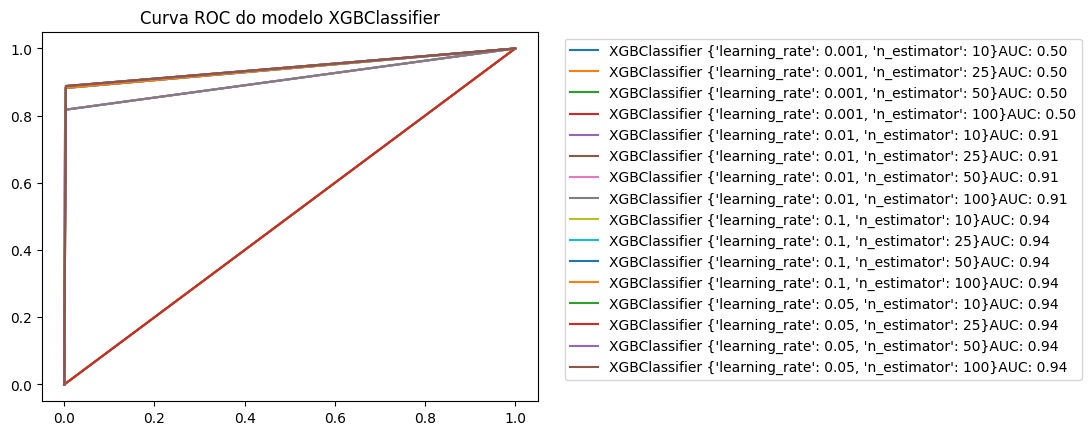

RandomForestClassifier {'n_estimators': 10}
RandomForestClassifier {'n_estimators': 25}
RandomForestClassifier {'n_estimators': 50}
RandomForestClassifier {'n_estimators': 100}
Melhor modelo:  {'train_score': 1.0, 'test_score': 0.934378366731308, 'params': {'n_estimators': 25}}


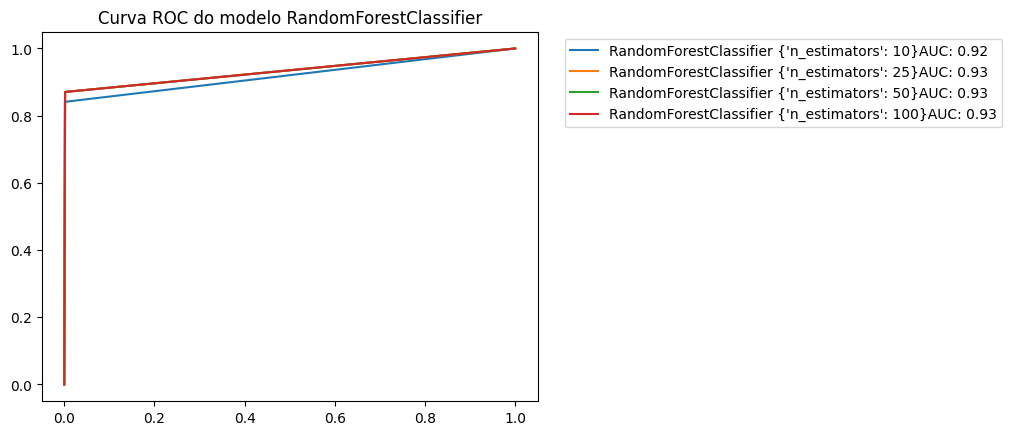

SVC {'C': 1.0, 'kernel': 'linear'}
SVC {'C': 1.0, 'kernel': 'rbf'}
SVC {'C': 1.0, 'kernel': 'poly'}
SVC {'C': 3.0, 'kernel': 'linear'}
SVC {'C': 3.0, 'kernel': 'rbf'}
SVC {'C': 3.0, 'kernel': 'poly'}
SVC {'C': 10.0, 'kernel': 'linear'}
SVC {'C': 10.0, 'kernel': 'rbf'}
SVC {'C': 10.0, 'kernel': 'poly'}
SVC {'C': 50.0, 'kernel': 'linear'}
SVC {'C': 50.0, 'kernel': 'rbf'}
SVC {'C': 50.0, 'kernel': 'poly'}
SVC {'C': 100.0, 'kernel': 'linear'}
SVC {'C': 100.0, 'kernel': 'rbf'}
SVC {'C': 100.0, 'kernel': 'poly'}
Melhor modelo:  {'train_score': 0.9849642759497593, 'test_score': 0.920782159017453, 'params': {'C': 100.0, 'kernel': 'rbf'}}


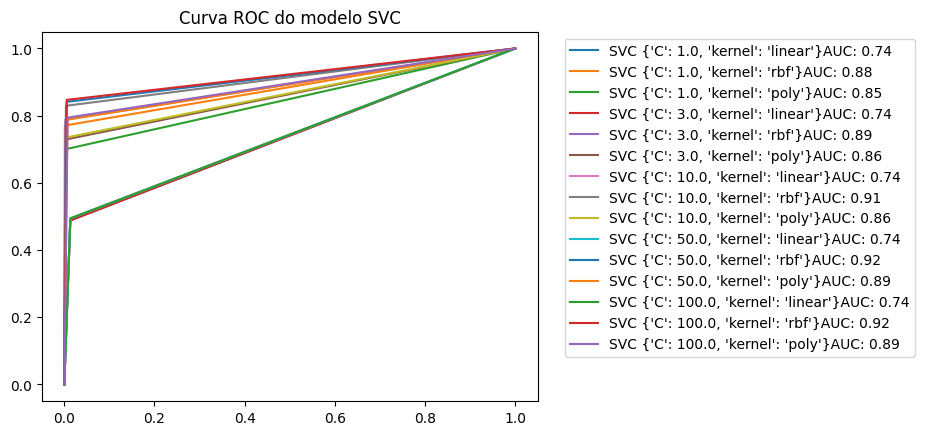

In [86]:
classifiers = {
    xgb.XGBClassifier: {"n_estimator": [10, 25, 50, 100], "learning_rate": [0.001, 0.01, 0.1, 0.05]},
    RandomForestClassifier: {"n_estimators": [10, 25, 50, 100]}, 
    SVC: {"C": [1.0, 3.0, 10.0, 50.0, 100.0], "kernel": ["linear", "rbf", "poly"]}
}

def roc_curve_and_auc(y, y_pred):
    fpr, tpr, _ = roc_curve(y, y_pred)
    score = auc(fpr, tpr)
    return (fpr, tpr, np.mean(score))


for classifier, params in classifiers.items():
    # Grid Search para o classificador
    grid = ParameterGrid(params)
    best_model = {"train_score": 0.0, "test_score": 0.0,"params": None}
    
    for param in grid:
        print(classifier.__name__ + " " + str(param))
        model = classifier(**param, random_state=SEED)
        train_score, test_score = boostraping(30, model, dataset_filtrado, "Personal.Loan", roc_curve_and_auc)

        # Fazer a média dos resultados 
        fpr, tpr, score = list(), list(), list()
        for f, t, s in test_score: 
            fpr.append(f)
            tpr.append(t) 
            score.append(s) 

        fpr = np.mean(fpr, axis=0)
        tpr = np.mean(tpr, axis=0)
        score = np.mean(score)
        
        # Plotar gráfico
        plt.plot(fpr, tpr, label = classifier.__name__ + " " + str(param) + "AUC: %.2f" % score)
       
    
        # Guardar o melhor modelo
        if np.mean(score) > best_model["test_score"]: 
            train_score = [s for _, _, s in train_score]
            best_model["train_score"] = np.mean(train_score)
            best_model["test_score"] = score
            best_model["params"] = param
    
    print("Melhor modelo: ", best_model)

    plt.title("Curva ROC do modelo " + classifier.__name__ )
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.show()

O XGBoost é o mais rápido a treinar, o que menos overfitou e o que tem melhor resultado com apenas 10 árvores de decisão e um learning rate de 0.05.

Utilizou-se AUC ROC (Receiver Operating Characteristic), porque Falsos Positivos é algo grave neste problema, já que classificar um individuo como válido para receber um empréstimo do banco e na realidade o individuo não ser válido é grave. Enquanto que os Falsos Negativos não são tão graves, porque classificar como inválido para fornecer empréstimo, acaba por ser uma atitude defensiva por parte do banco.

Como o ROC calcula a taxa de Verdadeiros Positivos e Falsos Positivos é uma medida útil para utilizar-se neste dataset, quanto maior os falsos positivos menor será o valor do ROC.

O AUC (Area Under Curve) do ROC permite calcular um único valor de score com base nas taxas de ROC.

Em termos de classificadores, os 3 têm resultados de 0.94 de AUC, com a floresta aleatória mantendo os resultados independente do número de árvores, o XGBoost com learning rate de 0.01 para cima e o SVC desde que use o kernel RBF (Radial Basis Function). Considerando a performance do XGBoost, conclui-se que este será o melhor dos 3.

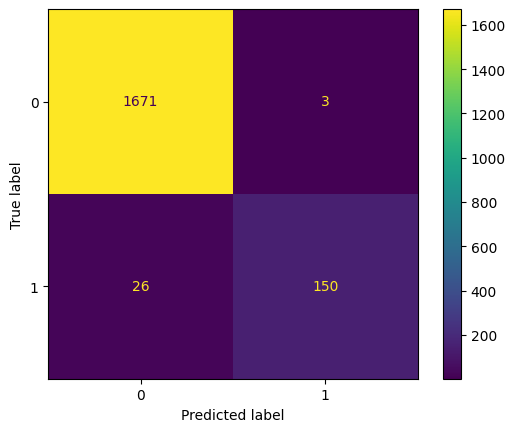

In [88]:
X, y = dataset_filtrado.drop(columns=["Personal.Loan"]), dataset_filtrado["Personal.Loan"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=int(len(dataset_filtrado) * 0.63),
                                                    shuffle=True, random_state=SEED)
model = xgb.XGBClassifier(n_estimator = 10, learning_rate = 0.05, random_state=SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
display.plot()

Pode-se observar que realmente há uma quantidade pequena de falsos positivos (3), havendo mais falsos negativos (26). Aqui também destaca-se o desequilibrio entre as classes, havendo significativamente mais registos com empréstimo rejeitado (0) do que com empréstimo aceite (1).

# Seleção do algoritmo de Regressão

Tendo os atributos selecionados e definidos os atributos alvos, serão testados 3 algoritmos de regressão:
* Support Vector Machine (SVM)
* Kernel Ridge
* XGBoost


O Kernel Ridge é parecido com um SVM só que usa outra função de custo para minimizar o gradiente e aplica uma penalização L2 (Ridge). Pode também utilizar kernels lineares ou não lineares.

In [ ]:
# Dataset só com os atributos selecionados + o atributo alvo
dataset_filtrado = df_filtrado_reg[list(sfs_reg.k_feature_names_) + ["Income"]]
dataset_filtrado

In [92]:
classifiers = {
    xgb.XGBRegressor: {"n_estimator": [10, 25, 50, 100], "learning_rate": [0.001, 0.01, 0.1, 0.05]},
    KernelRidge: {"alpha": [1.0, 3.0, 10.0, 50.0, 100.0], "kernel": ["linear", "rbf", "poly"]}, 
    SVR: {"C": [1.0, 3.0, 10.0, 50.0, 100.0], "kernel": ["linear", "rbf", "poly"]}
}

for classifier, params in classifiers.items():
    # Grid Search para o classificador
    grid = ParameterGrid(params)
    best_model = {
        "train_score": 0.0, 
        "test_score": 0.0,
        "params": None
    }
    
    for param in grid:
        print(classifier.__name__ + " " + str(param))
        
        if hasattr(classifier, "random_state"):
            model = classifier(**param, random_state=SEED)
        else:
            model = classifier(**param)
            
        train_score, test_score = boostraping(30, model, dataset_filtrado, "Income", r2_score)
    
        # Guardar o melhor modelo
        if np.mean(test_score) > best_model["test_score"]: 
            best_model["train_score"] = np.mean(train_score)
            best_model["test_score"] = np.mean(test_score)
            best_model["params"] = param
    
    print("Melhor modelo: ", best_model)

XGBRegressor {'learning_rate': 0.001, 'n_estimator': 10}
XGBRegressor {'learning_rate': 0.001, 'n_estimator': 25}
XGBRegressor {'learning_rate': 0.001, 'n_estimator': 50}
XGBRegressor {'learning_rate': 0.001, 'n_estimator': 100}
XGBRegressor {'learning_rate': 0.01, 'n_estimator': 10}
XGBRegressor {'learning_rate': 0.01, 'n_estimator': 25}
XGBRegressor {'learning_rate': 0.01, 'n_estimator': 50}
XGBRegressor {'learning_rate': 0.01, 'n_estimator': 100}
XGBRegressor {'learning_rate': 0.1, 'n_estimator': 10}
XGBRegressor {'learning_rate': 0.1, 'n_estimator': 25}
XGBRegressor {'learning_rate': 0.1, 'n_estimator': 50}
XGBRegressor {'learning_rate': 0.1, 'n_estimator': 100}
XGBRegressor {'learning_rate': 0.05, 'n_estimator': 10}
XGBRegressor {'learning_rate': 0.05, 'n_estimator': 25}
XGBRegressor {'learning_rate': 0.05, 'n_estimator': 50}
XGBRegressor {'learning_rate': 0.05, 'n_estimator': 100}
Melhor modelo:  {'train_score': 0.8511640830617615, 'test_score': 0.7542258761275169, 'params': {'le

Pode-se reparar que novamente, mesmo sendo como regressor, o XGBoost teve o melhor resultado e de forma mais rápida. O $R^2$ permite explicar o quão cada atributo preditivo explica o atributo alvo, tanto o SVR como o KernelRidge demonstrou-se fraco e lento. Possivelmente, os valores dos atributos permitem melhor criar regras com os atributos que melhor descrevem o atributo alvo do que serem modeladas por curvas de funções contínuas, principalmente porque há várias variáveis categóricas e dados com certas tendências.

# Clustering

In [31]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [148]:
# dataset_filtrado = df_filtrado[list(sfs_cls.k_feature_names_) + ["Personal.Loan"]]
# data = dataset_filtrado.drop(columns=["Personal.Loan"])
data = df_filtrado.copy()

Clustering é um tipo de aprendizagem não supervisionada, onde agrupam-se registos como base em relações encontradas entre os valores dos diversos atributos disponíveis.
Utilizar-se-á os seguintes algoritmos de clustering:
* KMeans
* DBSCAN
* AgglomerativeClustering

O KMeans baseia-se em criar clusters, cada um com um centro, e reavaliar cada registo de forma a corrigir a escolha do cluster para cada registo, com base no centro mais próximo, ajustando o seu centro. Parando quando não houver mais ajustes dos centros dos clusters. Para escolher o número de clusters que se pretende normalmente, utiliza-se o método do cotovelo, onde através da inércia (medida que mede a densidade dos clusters, quanto mais próximos os registos de um cluster estão, maior a densidade), encontra-se o número de clusters ideal no ponto onde a curva começa a estabilizar. Também pode-se usar outra métrica, como a silhueta que além de medir a densidade, mede a separação entre clusters, sendo assim mais robusta, varia entre [1,-1], sendo 1 o melhor valor possível.

O DBSCAN não utiliza parâmetros, é um método não paramétrico, agrupa os registos que estejam num certo raio, `eps` e garante que cada cluster tenha um certo número mínimo de registos.

O AgglomerativeClustering cria clusters e algomera-os recursivamente, começando com 1 registo por cluster. Há várias estratégias onde se pretende minimizar a distância entre registos, como o Ward que minimiza a variância entre clusters ou o complete que utiliza os registos mais distantes entre 2 clusters.

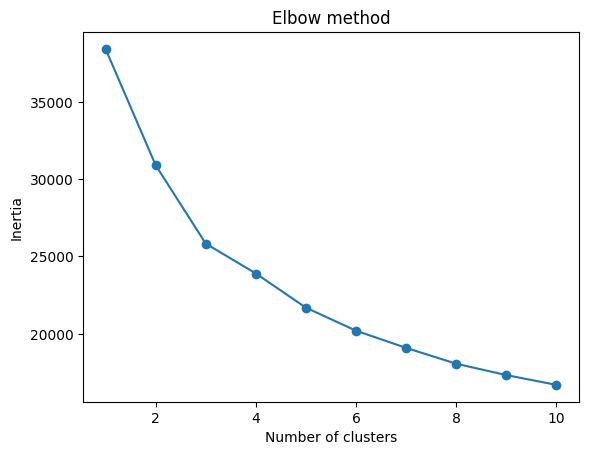

In [152]:
inertias = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, random_state=SEED)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)
plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Verifica-se que não há um estagnação da inércia, tendendo sempre a aumentar o número de clusters.

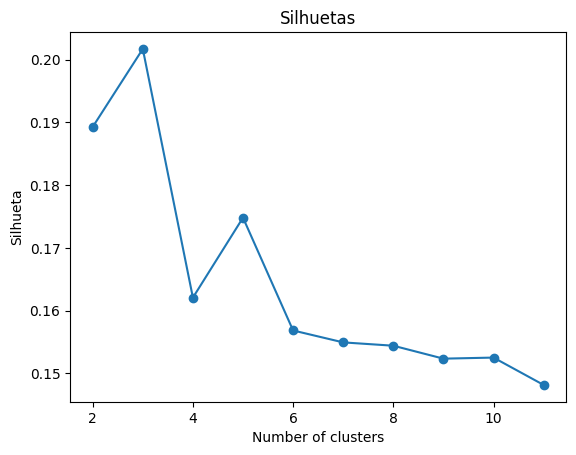

In [153]:
silhueta = []
for i in range(2,12):
    kmeans = KMeans(n_clusters=i, random_state=SEED)
    kmeans.fit(data)
    labels = kmeans.labels_
    silhueta.append(silhouette_score(data, labels))
plt.plot(range(2,12), silhueta, marker='o')
plt.title('Silhuetas')
plt.xlabel('Number of clusters')
plt.ylabel('Silhueta')
plt.show()


A silhueta mostrou um valor maior em 4 clusters, porém ainda está longe do valor 1 de silhueta.

In [155]:
db = DBSCAN(eps=1.4).fit(data)
labels = db.labels_

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print("Clusters: ", n_clusters)
print("Noise: ", n_noise)

Clusters:  2
Noise:  368


O DBSCAN com uma distância de 1.4, já que a distância mais comum entre os extremos de cada atributo é de 2, conseguiu criar somente 2 clusters, considerando que há 2 classes de registos, os que conseguiram e os que não conseguiram empréstimo. Então o DBScan apresentou melhores resultados que KMeans, o que significa que agrupar por vizinhanças com baixa distância funciona melhor do que a metodologia do KMeans. O DBSCAN também mostra o ruído, sendo este registos não encaixaram em nenhum cluster.

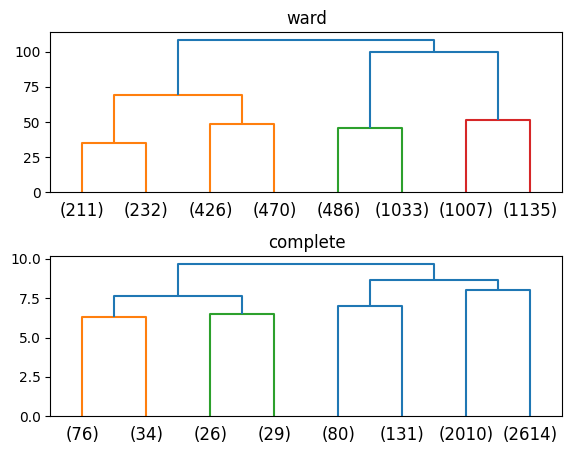

In [176]:
fig, (ax1, ax2) = plt.subplots(2, 1)

for ax, m in zip([ax1, ax2], ["ward", "complete"]):
    ax.set_title(m)
    linkage_matrix = linkage(data, method=m)
    dendrogram(linkage_matrix, truncate_mode="level", p=2, ax=ax)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

O dendograma mostra os clusters aglomerados ao longo do tempo até alcançarem uma folha. Na imagem o algoritmo ward faz uma separação mais equilibrada do que o complete, já que ele minimiza a distância entre 2 clusters. No entanto, sabe-se que os 2 clusters deste dataset são desiquilibrado com cerca de 4500 registos sem empréstimo e 500 com empréstimo.

Logo o complete aproximou-se mais dessa realidade. Possivelmente, porque o a estratégia completa ajusta-se melhor a datasets sem uma estrutura de dados óbvia.

In [194]:
model = AgglomerativeClustering(n_clusters=2, linkage="complete")
cluster_labels = model.fit_predict(data)

[0 0 0 ... 0 0 0]


In [195]:
_, contagens = np.unique(cluster_labels, return_counts=True)
print(contagens)

[4835  165]
